**IMDb**（Internet Movie Datebase ）是全球最大的互联网影视数据库，而[Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) 是一个根据IMDB上电影评论而建立的数据集。它由斯坦福大学于 2011 年发布。

![image-20201226152702981](images/image-20201226152702981.png)

## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf
from qbz95 import utils as qutils

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [74]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr



output_path = os.path.abspath('./output')
data_name = 'imdb'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['Negative', 'Positive']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'text_columns': 'snps_sa_comments',
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'stop_words':stopwords.words('english'),
    'batch_size': 32,    
    'max_features': 20000,
    'sequence_length': 500,    
    'epochs': 3,    
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':True,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': False,
            'schedule': lr_schedule,            
            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':15},
        'rnn':{'dropout':0.4, 'embedding_dim':200, 'units':200, 'epochs':5},
        'embedding':{'dropout':0.4, 'embedding_dim':200, 'epochs':15},
        'sepcnn':{'dropout':0.4, 'epochs': 10, 'batch_size':128},
        'tl':{'dropout':0.4, 'trainable':True, 'layer_count':1, 'unit':64, 'epochs': 10},
        'pg':{'dropout':0.4, 'embedding_dim':300, 'units':80, 'epochs':10, 'learning_rate':0.0005},  
    },
    'embedding_paths':{
        'cc_en_300':os.path.join(word_vectors_path, 'snps', 'cc.en.300.vec'),
        'fasttext_crawl_300d_2M':os.path.join(word_vectors_path, 'fasttext-crawl-300d-2M.vec'),
        'glove_twitter_27B_200d':os.path.join(word_vectors_path, 'glove.twitter.27B.200d.txt')
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2022-07-19 06:33:58,168: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json


### 下载数据

开始下载数据。

In [4]:
dataset_dir =  os.path.join(os.path.expanduser('~'), '.keras/datasets/aclImdb') 
if not os.path.exists(dataset_dir):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True)
    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
    print(dataset_dir)

![image-20201217095446441](images/image-20201217095446441.png)

下面是压缩文件解开后的目录结构。

![image-20201104115404253](images/image-20201104115404253.png)

其中train和test目录包含了实际的文本数据，详细说明见[IMDB](https://eipi10.cn/others/2020/10/22/dataset/#imdb---large-movie-review-dataset)。

### 查看数据

下面看一看实际的数据是啥样的。

In [5]:
def get_files(base_dir):
    pos_dir = os.path.join(base_dir, 'pos')
    pos_files = os.listdir(pos_dir)
    pos_files = [os.path.join(pos_dir, file_name) for file_name in pos_files]
    
    neg_dir = os.path.join(base_dir, 'neg')
    neg_files = os.listdir(neg_dir)
    neg_files = [os.path.join(neg_dir, file_name) for file_name in neg_files]    

    return pos_files, neg_files

train_pos_files, train_neg_files = get_files(os.path.join(dataset_dir, 'train'))
test_pos_files, test_files = get_files(os.path.join(dataset_dir, 'test'))
    
print('train dataset: {} positive reviews, {} negative reviews'.format(len(train_pos_files), len(train_neg_files)))
print('test dataset: {} positive reviews, {} negative reviews'.format(len(test_pos_files), len(test_files)))

train dataset: 12500 positive reviews, 12500 negative reviews
test dataset: 12500 positive reviews, 12500 negative reviews


![image-20201217115036617](images/image-20201217115036617.png)

首先看一看正面的评论。

In [6]:
for file_path in train_pos_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...') 

------------------------------/root/.keras/datasets/aclImdb/train/pos/127_7.txt------------------------------
Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.
------------------------------/root/.keras/datasets/aclImdb/train/pos/126_10.txt------------------------------
Zentropa is the most original movie I've seen in y

![image-20201217111649607](images/image-20201217111649607.png)

然后看一看负面的评论。

In [7]:
for file_path in train_neg_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...')

------------------------------/root/.keras/datasets/aclImdb/train/neg/127_4.txt------------------------------
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher ...
------------------------------/root/.keras/datasets/aclImdb/train/neg/126_1.txt------

![image-20201217100213645](images/image-20201217100213645.png)

## 探索数据

接下来，对把数据加载进内存，进行深入一些的探索。

### 基本信息

In [8]:
def get_samples(texts, labels, rate):
    indexs = np.arange(len(texts))
    sample_indexs, _, sample_labels, _ = train_test_split(indexs, labels,                                                          
                                                          test_size=1-rate,
                                                          random_state=12)
    sample_texts = [texts[index] for index in sample_indexs]
    return sample_texts, sample_labels    

def load_imdb_sentiment_analysis_dataset(imdb_data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

(train_texts, train_labels), (test_texts, test_labels) = load_imdb_sentiment_analysis_dataset(dataset_dir)

if params.sample_perecent<1:
    train_texts, train_labels = get_samples(train_texts, train_labels, rate=params.sample_perecent)
    test_texts, test_labels = get_samples(test_texts, test_labels, rate=params.sample_perecent)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=25000, train_labels.shape=(25000,)
test_texts.length=25000, test_labels.shape=(25000,)


![image-20201217122349480](images/image-20201217122349480.png)

### 类别分布

下面看看类别的分布。可以看到数据分为Positive和Negative两类，数据分布完全均匀。

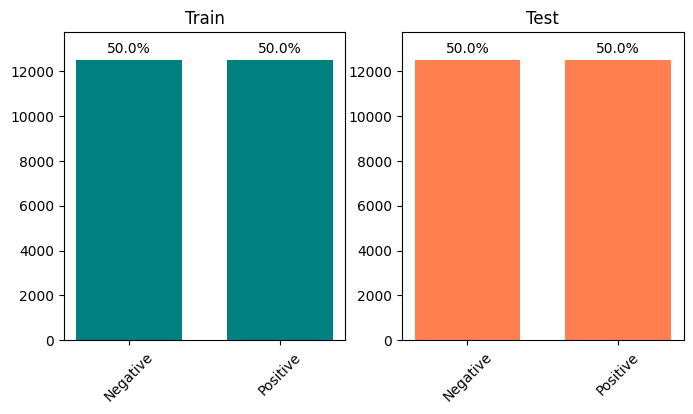

In [9]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



### 文本长度分布

分析训练集和测试集的文本长度分布是否相似。

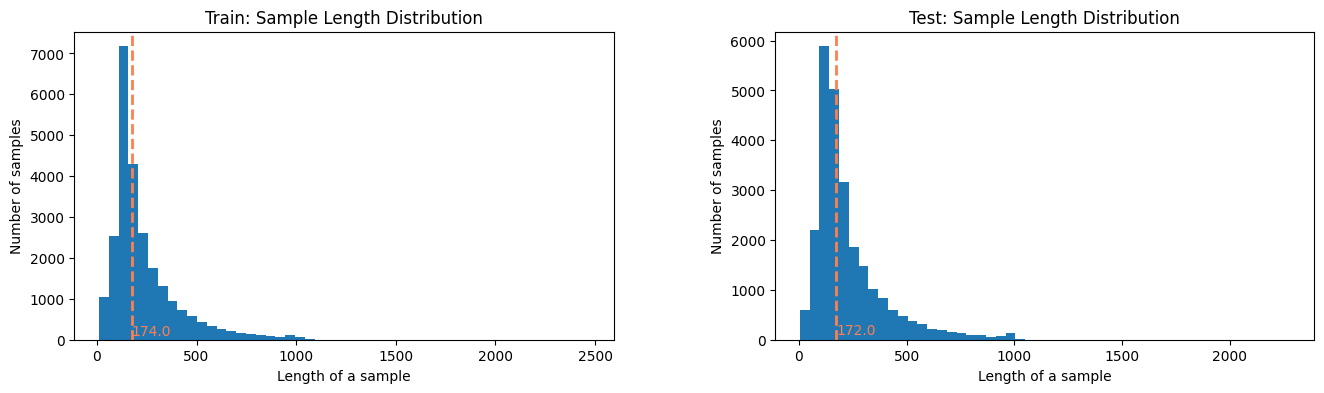

train：mean=233.79 variance=30181.96
test：mean=228.53 variance=28520.56


In [10]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
qtf.utils.plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))


通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [11]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3091,11744,4697,2321,1251,752,434,289,421,25000
train,2926,11654,4665,2385,1340,786,464,307,473,25000
合计,6017,23398,9362,4706,2591,1538,898,596,894,50000


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3008.5,11699.0,4681.0,2353.0,1295.5,769.0,449.0,298.0,447.0,25000.0
train,3008.5,11699.0,4681.0,2353.0,1295.5,769.0,449.0,298.0,447.0,25000.0
合计,6017.0,23398.0,9362.0,4706.0,2591.0,1538.0,898.0,596.0,894.0,50000.0


![image-20210101174143400](images/image-20210101174143400.png)

然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [12]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 14.229826210223425
critical_value = 15.50731305586545
p_value = 0.07596828551367163



### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

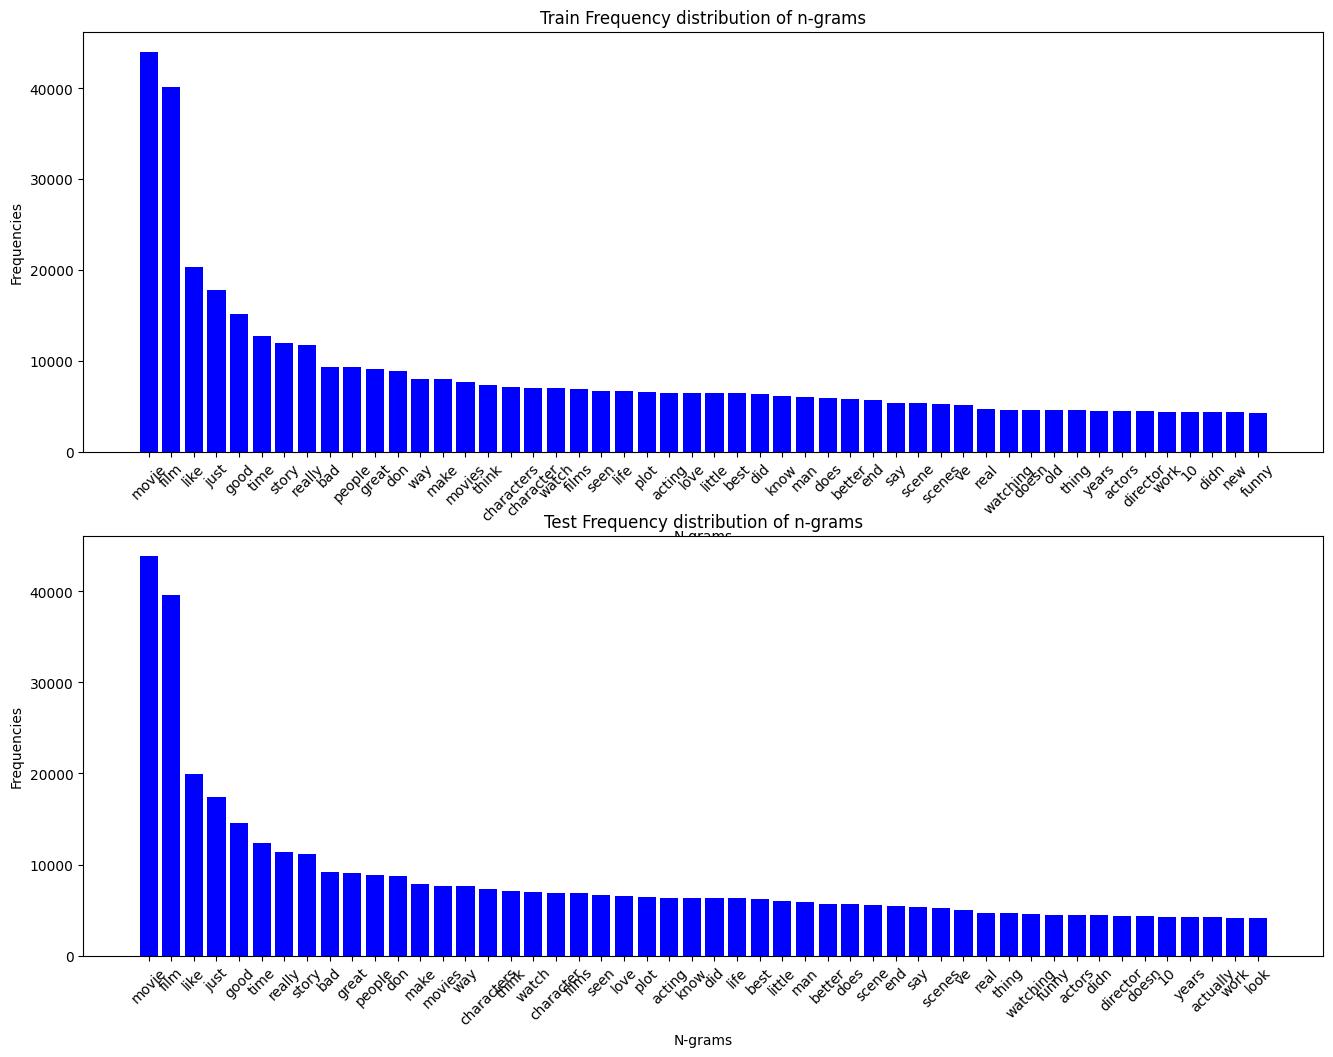

In [13]:
qtf.utils.plot_frequency_distribution(train_texts, test_texts) 

In [14]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<25: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 438729
Number of Vocabulary: 23078


![image-20201217142728260](images/image-20201217142728260.png)

上面可以看到词频大于等于100次的词汇有7706个。

## 准备数据

不同的模型需要准备不同的数据，所以徐要确定一下要构建哪种模型。

### 模型选择

下图是google在两年前提出一个选择流程图。

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
   a. Split the samples into word n-grams; convert the n-grams into vectors.
     b. Score the importance of the vectors and then select the top 20K using the scores.
   c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
   a. Split the samples into words; select the top 20K words based on their frequency.
   b. Convert the samples into word sequence vectors.
   c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [15]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 143.7


可以看到这个比例大大小于15k，所以我们从N-gram模型开始，但是同时我们也会为Sequence模型准备数据。数据准备有如下几个过程。
1. Standardization 
   
   文本标准化操作，去除一些不合规范的字符或单词等。比如：去除拼音和HTML标记
   
   
2. Tokenization

   把文本字符串拆分成Token。对于英文最常见的拆分方式是根据空格拆分
   
   
3. Vectorization

   把Token转化为向量。
   

接下来，我们将分别为N-gram模型和Sequence模型准备数据。


### Raw + Preprocess

In [16]:
generator = qtf.classification.RawGenerator('raw_preprocess', standardize=qtf.text.standardize_text1)
raw_datasets = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                           generator=generator, batch_size=params.batch_size)

In [17]:
data, labels = iter(raw_datasets.train_dataset).next()
print(type(data))
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), type(item)) 

<class 'tensorflow.python.framework.ops.EagerTensor'>
(32,) (32,)
---------------------------------------- Positive ----------------------------------------
b'what a night . perry mason then have gun , will travel followed by gunsmoke when it was a half hour and finally at pm came sea hunt with its wonderful opening theme music and mike s boat sailing off to a new adventure . terrific . . regardless of the story it was the lead character played by lloyd bridges , strong , honest , sincere . a man s man and a boy s man . this brought on an interest in boats that lasted for years . why they don t show on cable or make it available on video , no idea . . too bad . ' <class 'tensorflow.python.framework.ops.EagerTensor'>
---------------------------------------- Negative ----------------------------------------
b'my wife and i just finished this movie and i came onto to imdb to commiserate with the reviewers that found this movie less than satisfactory . however , of the pages of reviews , o



### N-gram + Preprocess

在N-gram模型中，Tokenization一般使用unigrams + bigrams的方式把文本转成Token，而Vectorization过程，一般先统计Token的BOW（Bag of Words，词袋模型），然后采用tf-idf在对词频进行平衡。

In [18]:
stop_words = params.stop_words if params.use_stop_words else None
generator = qtf.classification.NgramGenerator('ngram_preproess', standardize=qtf.text.standardize_text1,
                                    texts=train_texts, labels=train_labels, max_feature=params.max_features, 
                                    stop_words=stop_words)
ngram_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                              generator=generator, batch_size=params.batch_size)

In [19]:
data, labels = iter(ngram_datasets1.train_dataset).next()
print(type(data))
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(tf.sparse.to_dense(data), labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(np.any(item.numpy()>0), item.shape)
    print(item.numpy()[-100:])

<class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>
(32, 20000) (32,)
---------------------------------------- Positive ----------------------------------------
True (20000,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
---------------------------------------- Positive ----------------------------------------
True (20000,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
---------------------------------------- Negative ----------------------------------------
True

### Sequence + Preprocess

In [20]:
generator = qtf.classification.SequenceGenerator('sequence_prepross', standardize=qtf.text.standardize_text1, 
                                       texts=train_texts, max_features=params.max_features, 
                                       max_sequence_length=params.sequence_length)
sequence_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                                 generator=generator, batch_size=params.batch_size) 

In [21]:
data, labels = iter(sequence_datasets1.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 500) (32,)
---------------------------------------- Negative ----------------------------------------
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     

### N-gram + Process

In [22]:
generator = qtf.classification.LayerGenerator.get_ngram_layer(name='ngram_map', standardize=qtf.text.standardize_tf_text1, 
                                                        texts=train_texts[0:1000], max_features=params.max_features)
ngram_datasets2 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                              generator=generator, batch_size=params.batch_size)

In [23]:
data, labels = iter(ngram_datasets2.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 20000) (32,)
---------------------------------------- Positive ----------------------------------------
[873.06934     7.6411567   6.9414864 ...   0.          0.
   0.       ] (20000,)
---------------------------------------- Positive ----------------------------------------
[912.53015     9.0304575   9.023932  ...   0.          0.
   0.       ] (20000,)
---------------------------------------- Positive ----------------------------------------
[241.69717     2.7786024   2.082446  ...   0.          0.
   0.       ] (20000,)
---------------------------------------- Negative ----------------------------------------
[300.8883      0.          4.8590407 ...   0.          0.
   0.       ] (20000,)
---------------------------------------- Positive ----------------------------------------
[636.3048     4.862554   8.329784 ...   0.         0.         0.      ] (20000,)


### Sequence + Process

![Embedding Layer](images/EmbeddingLayer.png)

如上图所示，和N-gram模型不同，Sequence模型并不统计词频，它保持了文本的原始顺序，把其中的每个词汇单独变成一个One-hot向量，然后采用Word embedding的方式生成更加有意义的词向量，最后输出到RNN，CNN等模型中。

In [24]:
ngrams = (1, 2)
output_mode = 'tf-idf'
max_sequence_length = None
data = train_texts[0:1000]

layer = TextVectorization(
            max_tokens=params.max_features, standardize=qtf.text.standardize_tf_text1,
            split='whitespace', ngrams=ngrams, output_mode=output_mode,
            output_sequence_length=max_sequence_length, pad_to_max_tokens=False,
            vocabulary=None
        )



In [25]:
generator = qtf.classification.LayerGenerator.get_sequence_layer(name='sequence_map', 
                                                       standardize=qtf.text.standardize_tf_text1, 
                                                       texts=train_texts[0:1000], 
                                                       max_features=params.max_features,
                                                       max_sequence_length=params.sequence_length)
sequence_datasets2 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels,   
                                                 generator=generator, batch_size=params.batch_size)

In [26]:
data, labels = iter(sequence_datasets2.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 500) (32,)
---------------------------------------- Positive ----------------------------------------
[11453     5 14989  1229  7547  1995     6   576     5  5086   210    35
     2   140  4565  1908  1370   204  9143    24     6 17582  2957  1239
    97    30    16     1     1    35  5659     5  5235  6585     1     1
   241     8     2  5573     1    35   916 15293     4    41    49  1995
     5    29  1258   998  2954    20     6   157  4298 18757     7     1
     1     1     3  1995 15195     6 13436     1  1490     7     1 13646
     5    49     8  6470    14  1490    59     2   157   998  3663    19
     6  2282  9038     3   161   466  1596     3    16     3  5255     4
   927    40     6  1607     5  4606   235    35   579     1  5833     4
  4152     6  5138  1843     7     6  3188     4  1492     5  2721   758
   808   650   134  8307     6 11740  1747     5     6  1712     4  2729
   827   557     3 14187     4  5255  8739   974   400     7  2084    88
  1995    16  152

In [27]:
vocabulary = generator.layer.get_vocabulary()

embedding_files = [params.embedding_paths.fasttext_crawl_300d_2M]
embedding_matrix_fasttext = qtf.text.load_embedding_matrix(embedding_files,
                                                           vocabulary=vocabulary,
                                                           max_features=params.max_features,
                                                           max_length=1000000,
                                                           ignore_rows=0
                                                           )

2022-07-19 04:12:12,663: INFO: --------------------------------------------------------------------------------
2022-07-19 04:13:17,937: INFO: Loaded 1000000 word vectors. the vector size is 300
2022-07-19 04:13:18,000: INFO: embedding_matrix.shape: (19776, 300)
2022-07-19 04:13:18,001: INFO: match count: 17746
2022-07-19 04:13:18,002: INFO: missing word count: 2030




##  模型

### MLP

#### mp1

2022-07-18 09:24:12,708: INFO: model_params.mlp1.dropout=0.6
2022-07-18 09:24:12,708: INFO: model_params.mlp1.layer_count=1
2022-07-18 09:24:12,709: INFO: model_params.mlp1.units=256
2022-07-18 09:24:12,732: INFO: output_bias=[-0.69314718 -0.69314718]
2022-07-18 09:24:12,739: INFO: learning_rate=0.001
2022-07-18 09:24:12,740: INFO: model_params.mlp1.clip_value=None
2022-07-18 09:24:12,745: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1


SparseTensorSpec(TensorShape([32, 20000]), tf.float32)
Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 20000)]           0         
                                                                 
 lambda (Lambda)             (None, 20000)             0         
                                                                 
 dropout_2 (Dropout)         (None, 20000)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               5120256   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 514       
                                                                 
Total p

2022-07-18 09:24:12,757: INFO: model_params.mlp1.epochs=15
2022-07-18 09:24:12,758: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1, monitor=val_accuracy)
2022-07-18 09:24:12,758: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-07-18 09:24:12,759: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-07-18 09:24:12,759: INFO: use LearningRateScheduler()
2022-07-18 09:24:12,760: INFO: steps_per_epoch=None
2022-07-18 09:24:12,760: INFO: start training
2022-07-18 09:24:12,761: INFO: use_class_weight=False


Epoch 1/15
773/781 [============================>.] - ETA: 0s - loss: 0.3937 - accuracy: 0.8282INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1/assets


2022-07-18 09:24:17,937: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1/assets


781/781 [==============================] - 5s 6ms/step - loss: 0.3927 - accuracy: 0.8286 - val_loss: 0.2734 - val_accuracy: 0.8886 - lr: 0.0010
Epoch 2/15
781/781 [==============================] - ETA: 0s - loss: 0.2595 - accuracy: 0.8910INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1/assets


2022-07-18 09:24:22,635: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1/assets


781/781 [==============================] - 5s 6ms/step - loss: 0.2595 - accuracy: 0.8910 - val_loss: 0.2676 - val_accuracy: 0.8896 - lr: 0.0010
Epoch 3/15
781/781 [==============================] - 4s 5ms/step - loss: 0.2262 - accuracy: 0.9062 - val_loss: 0.2706 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 4/15
781/781 [==============================] - 4s 5ms/step - loss: 0.2107 - accuracy: 0.9120 - val_loss: 0.2836 - val_accuracy: 0.8836 - lr: 0.0010
Epoch 5/15
781/781 [==============================] - 4s 5ms/step - loss: 0.1963 - accuracy: 0.9186 - val_loss: 0.2872 - val_accuracy: 0.8831 - lr: 0.0010
Epoch 6/15
781/781 [==============================] - 4s 5ms/step - loss: 0.1879 - accuracy: 0.9238 - val_loss: 0.2891 - val_accuracy: 0.8821 - lr: 0.0010
Epoch 7/15
781/781 [==============================] - 4s 5ms/step - loss: 0.1804 - accuracy: 0.9232 - val_loss: 0.2957 - val_accuracy: 0.8821 - lr: 0.0010
Epoch 8/15
781/781 [==============================] - 4s 5ms/step - loss: 0.1725 

2022-07-18 09:25:13,878: INFO: finish training [elapsed time: 61.12 seconds]


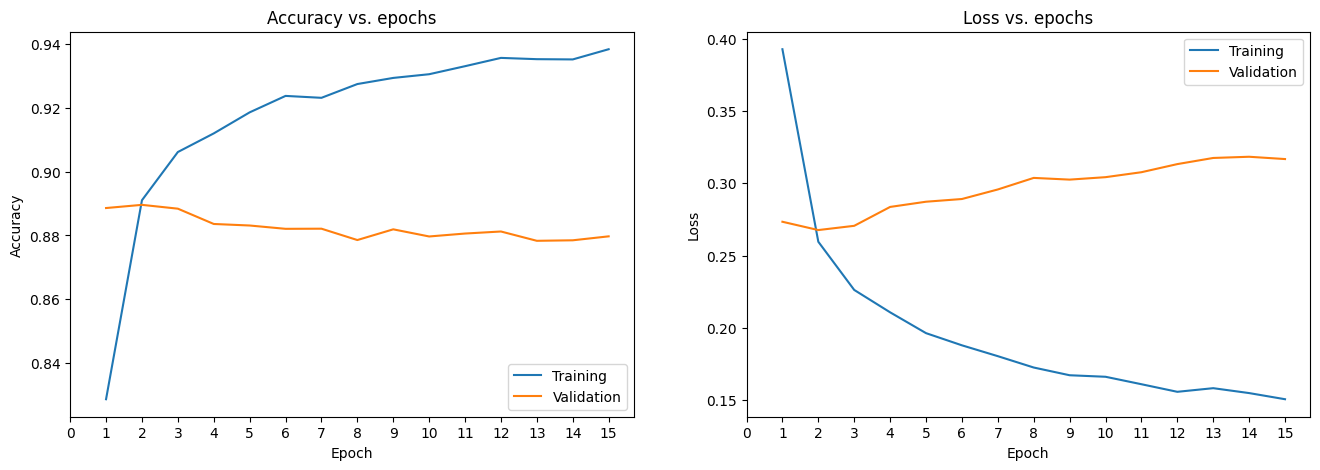

2022-07-18 09:25:14,281: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1
----------------------------------------evaluate----------------------------------------


2022-07-18 09:26:05,365: INFO: test loss:0.2676
2022-07-18 09:26:05,365: INFO: test accuracy:0.8896
2022-07-18 09:26:05,367: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2022-07-18 09:26:05,369: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2022-07-18 09:26:05,369: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_preproess.generator


----------------------------------------save model results and generator----------------------------------------


2022-07-18 09:26:06,006: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_preproess.generator
2022-07-18 09:26:06,007: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft


----------------------------------------confusion matrix----------------------------------------


2022-07-18 09:26:13,458: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 09:26:13,478: INFO: loading layer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl


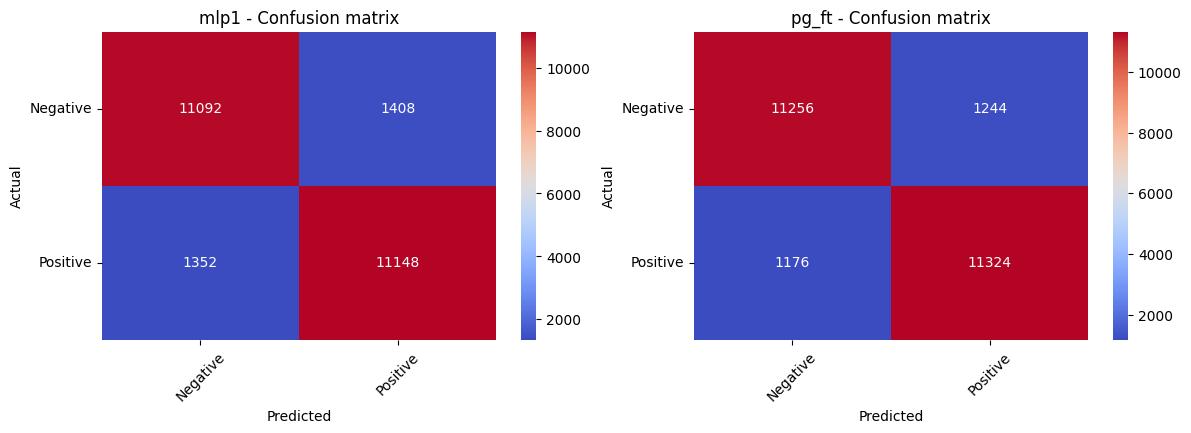

2022-07-18 09:26:37,704: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft


----------------------------------------sample analysis----------------------------------------


2022-07-18 09:26:43,675: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 09:26:43,693: INFO: loading layer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl
2022-07-18 09:26:43,882: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default
2022-07-18 09:26:51,092: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 09:26:51,093: INFO: loading layer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl
2022-07-18 09:26:51,282: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classif

----------------------------------------1. Positive----------------------------------------
Actor turned director Bill Paxton follows up his promising debut, the Gothic-horror "Frailty", with this family friendly sports drama about the 1913 U.S. Open where a young American caddy rises from his humble background to play against his Bristish idol in what was dubbed as "The Greatest Game Ever Played." I'm no fan of golf, and these scrappy underdog sports flicks are a dime a dozen (most recently done to grand effect with "Miracle" and "Cinderella Man"), but some how this film was enthralling all the same.<br /><br />The film starts with some creative opening credits (imagine a Disneyfied version of the animated opening credits of HBO's "Carnivale" and "Rome"), but lumbers along slowly for its first by-the-numbers hour. Once the action moves to the U.S. Open things pick up very well. Paxton does a nice job and shows a knack for effective directorial flourishes (I loved the rain-soaked monta

2022-07-18 09:27:27,974: WARNING: 5 out of the last 1569 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f0d9f270310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


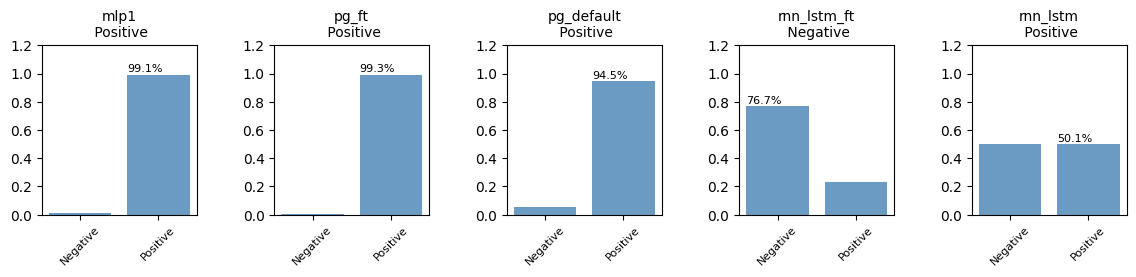

----------------------------------------2. Negative----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


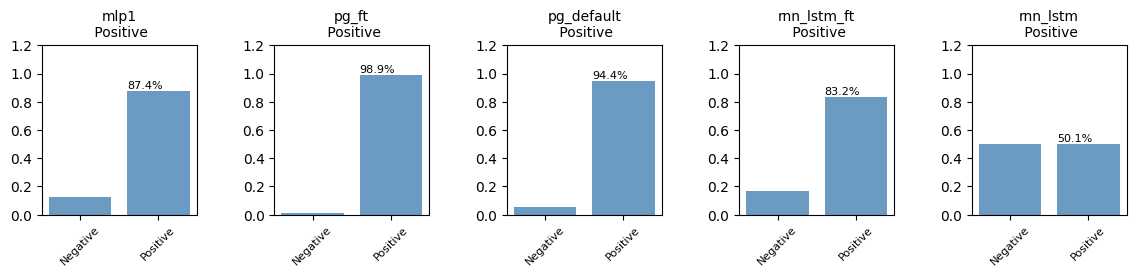

----------------------------------------3. Negative----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


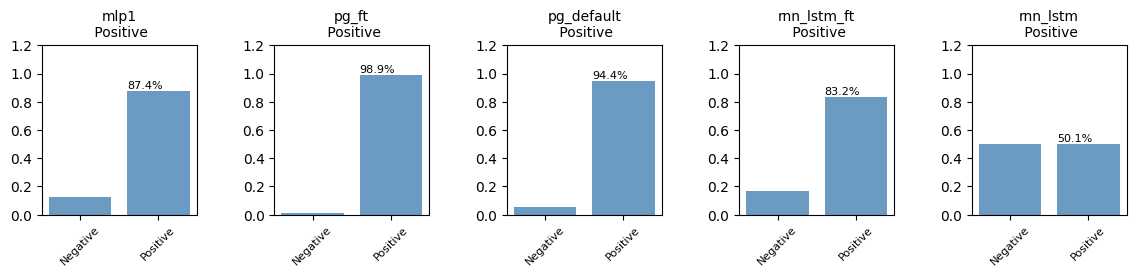

----------------------------------------4. Positive----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


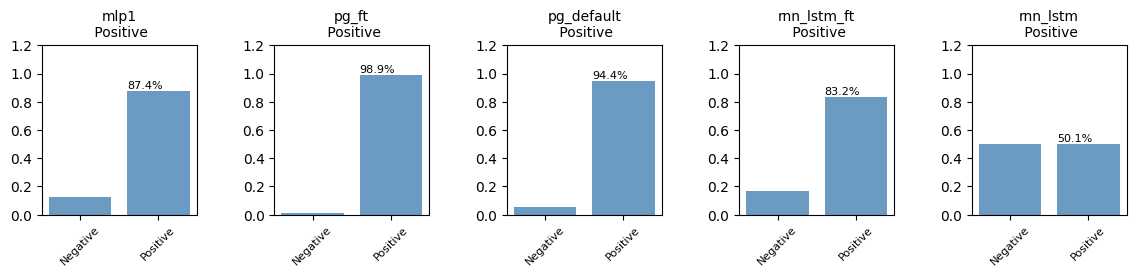

----------------------------------------5. Negative----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


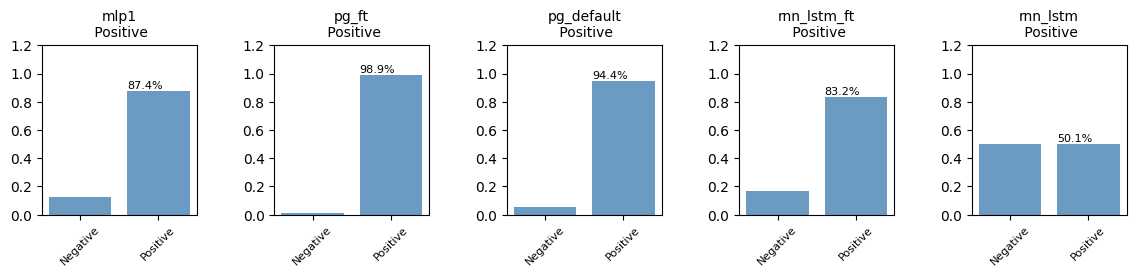

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,pg_ft,imdb_0721_p100.ipynb,6116802,402.5,2022-07-18 09:23,0.1248,0.2414,0.9556,0.9032,0.9904,0.9659
2,mlp1,imdb_0721_p100.ipynb,5120770,61.1,2022-07-18 09:26,0.1389,0.2676,0.9546,0.8896,0.9911,0.9563
3,pg_default,imdb_0721_p100.ipynb,6184002,390.8,2022-07-18 09:15,0.1502,0.2750,0.9529,0.8853,0.9891,0.9548
4,rnn_lstm_ft,imdb_0721_p100.ipynb,1282802,557.9,2022-07-18 08:55,0.3591,0.3658,0.8550,0.8489,0.9268,0.9248
5,rnn_lstm,imdb_0721_p100.ipynb,5123002,569.9,2022-07-18 08:43,0.6494,0.7105,0.5776,0.5329,0.6319,0.5445


In [34]:
helper = qtf.classification.Classification(params, datasets=ngram_datasets1, model_results=model_results)
model = qtf.classification.text_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True)

#### mlp2

2022-07-18 09:27:32,955: INFO: model_params.mlp2.dropout=0.6
2022-07-18 09:27:32,956: INFO: model_params.mlp2.layer_count=1
2022-07-18 09:27:32,957: INFO: model_params.mlp2.units=256
2022-07-18 09:27:32,981: INFO: output_bias=[-0.69314718 -0.69314718]
2022-07-18 09:27:32,989: INFO: learning_rate=0.001
2022-07-18 09:27:32,989: INFO: model_params.mlp2.clip_value=None
2022-07-18 09:27:32,994: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2


TensorSpec(shape=(32, 20000), dtype=tf.float32, name=None)
Model: "mlp2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dropout_4 (Dropout)         (None, 20000)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               5120256   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 2)                 514       
                                                                 
Total params: 5,120,770
Trainable params: 5,120,770
Non-trainable params: 0
___________________________________________________________

2022-07-18 09:27:33,004: INFO: model_params.mlp2.epochs=15
2022-07-18 09:27:33,005: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2, monitor=val_accuracy)
2022-07-18 09:27:33,005: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-07-18 09:27:33,006: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-07-18 09:27:33,007: INFO: use LearningRateScheduler()
2022-07-18 09:27:33,007: INFO: steps_per_epoch=None
2022-07-18 09:27:33,008: INFO: start training
2022-07-18 09:27:33,008: INFO: use_class_weight=False


Epoch 1/15
778/781 [============================>.] - ETA: 0s - loss: 0.8477 - accuracy: 0.7625INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2/assets


2022-07-18 09:27:59,079: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2/assets


781/781 [==============================] - 26s 33ms/step - loss: 0.8463 - accuracy: 0.7627 - val_loss: 0.3856 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 2/15
781/781 [==============================] - 4s 5ms/step - loss: 0.3910 - accuracy: 0.8376 - val_loss: 0.3675 - val_accuracy: 0.8530 - lr: 0.0010
Epoch 3/15
778/781 [============================>.] - ETA: 0s - loss: 0.3564 - accuracy: 0.8505INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2/assets


2022-07-18 09:28:07,654: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2/assets


781/781 [==============================] - 4s 6ms/step - loss: 0.3561 - accuracy: 0.8506 - val_loss: 0.2995 - val_accuracy: 0.8888 - lr: 0.0010
Epoch 4/15
770/781 [============================>.] - ETA: 0s - loss: 0.3350 - accuracy: 0.8627INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2/assets


2022-07-18 09:28:12,216: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2/assets


781/781 [==============================] - 5s 6ms/step - loss: 0.3346 - accuracy: 0.8628 - val_loss: 0.3094 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 5/15
781/781 [==============================] - 4s 5ms/step - loss: 0.3175 - accuracy: 0.8691 - val_loss: 0.2846 - val_accuracy: 0.8939 - lr: 0.0010
Epoch 6/15
781/781 [==============================] - 4s 5ms/step - loss: 0.3125 - accuracy: 0.8753 - val_loss: 0.2841 - val_accuracy: 0.8926 - lr: 0.0010
Epoch 7/15
781/781 [==============================] - 4s 5ms/step - loss: 0.2954 - accuracy: 0.8808 - val_loss: 0.2905 - val_accuracy: 0.8894 - lr: 0.0010
Epoch 8/15
781/781 [==============================] - 4s 5ms/step - loss: 0.2906 - accuracy: 0.8837 - val_loss: 0.2826 - val_accuracy: 0.8930 - lr: 0.0010
Epoch 9/15
781/781 [==============================] - 4s 5ms/step - loss: 0.2836 - accuracy: 0.8871 - val_loss: 0.2920 - val_accuracy: 0.8816 - lr: 0.0010
Epoch 10/15
773/781 [============================>.] - ETA: 0s - loss: 0.2823 - a

2022-07-18 09:28:35,983: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2/assets


781/781 [==============================] - 4s 6ms/step - loss: 0.2822 - accuracy: 0.8877 - val_loss: 0.2735 - val_accuracy: 0.8960 - lr: 0.0010
Epoch 11/15
781/781 [==============================] - 4s 5ms/step - loss: 0.2755 - accuracy: 0.8904 - val_loss: 0.2673 - val_accuracy: 0.8955 - lr: 0.0010
Epoch 12/15
781/781 [==============================] - 4s 5ms/step - loss: 0.2762 - accuracy: 0.8921 - val_loss: 0.2685 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 13/15
768/781 [============================>.] - ETA: 0s - loss: 0.2573 - accuracy: 0.8978INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2/assets


2022-07-18 09:28:48,463: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2/assets


781/781 [==============================] - 5s 6ms/step - loss: 0.2574 - accuracy: 0.8979 - val_loss: 0.2693 - val_accuracy: 0.8965 - lr: 0.0010
Epoch 14/15
781/781 [==============================] - 4s 5ms/step - loss: 0.2621 - accuracy: 0.8957 - val_loss: 0.2723 - val_accuracy: 0.8950 - lr: 0.0010
Epoch 15/15
781/781 [==============================] - 4s 5ms/step - loss: 0.2641 - accuracy: 0.8979 - val_loss: 0.2773 - val_accuracy: 0.8934 - lr: 0.0010


2022-07-18 09:28:56,160: INFO: finish training [elapsed time: 83.15 seconds]


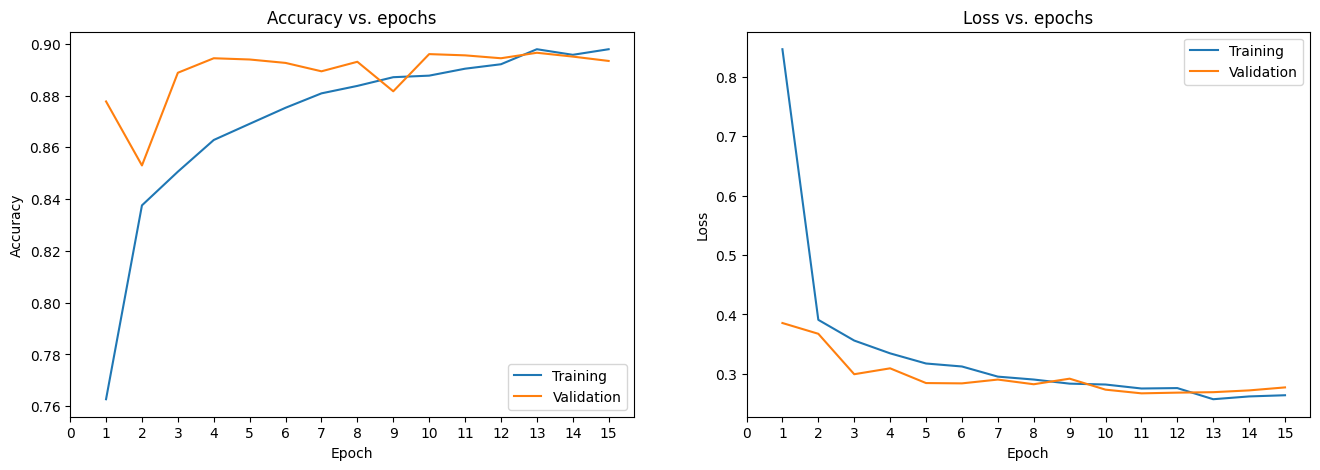

2022-07-18 09:28:56,568: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2
----------------------------------------evaluate----------------------------------------


2022-07-18 09:29:48,761: INFO: test loss:0.2693
2022-07-18 09:29:48,762: INFO: test accuracy:0.8965
2022-07-18 09:29:48,763: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2022-07-18 09:29:48,764: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2022-07-18 09:29:48,765: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_map.generator
2022-07-18 09:29:48,807: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_map.pkl
2022-07-18 09:29:48,808: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_map.generator
2022-07-18 09:29:48,808: INFO: loading model fro

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-07-18 09:29:56,699: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 09:29:56,714: INFO: loading layer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl


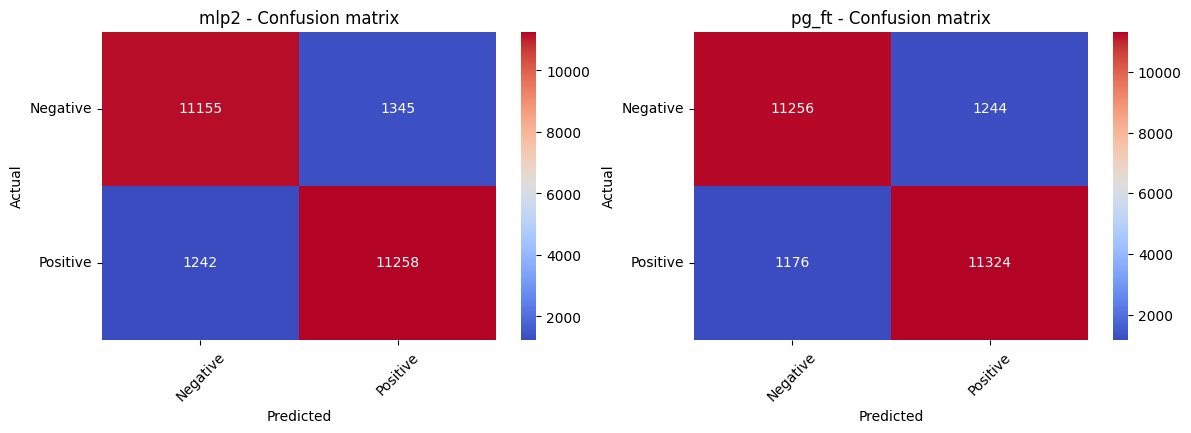

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,pg_ft,imdb_0721_p100.ipynb,6116802,402.5,2022-07-18 09:23,0.1248,0.2414,0.9556,0.9032,0.9904,0.9659
2,mlp2,imdb_0721_p100.ipynb,5120770,83.2,2022-07-18 09:29,0.1467,0.2693,0.9682,0.8965,0.9956,0.9600
3,mlp1,imdb_0721_p100.ipynb,5120770,61.1,2022-07-18 09:26,0.1389,0.2676,0.9546,0.8896,0.9911,0.9563
4,pg_default,imdb_0721_p100.ipynb,6184002,390.8,2022-07-18 09:15,0.1502,0.2750,0.9529,0.8853,0.9891,0.9548
5,rnn_lstm_ft,imdb_0721_p100.ipynb,1282802,557.9,2022-07-18 08:55,0.3591,0.3658,0.8550,0.8489,0.9268,0.9248
6,rnn_lstm,imdb_0721_p100.ipynb,5123002,569.9,2022-07-18 08:43,0.6494,0.7105,0.5776,0.5329,0.6319,0.5445


In [35]:
helper = qtf.classification.Classification(params, datasets=ngram_datasets2, model_results=model_results)
model = qtf.classification.text_models.mlp1(helper, name='mlp2')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### Embedding

#### embedding1

2022-07-18 09:30:21,523: INFO: model_params.embedding1.dropout=0.4
2022-07-18 09:30:21,524: INFO: model_params.embedding1.embedding_dim=200
2022-07-18 09:30:21,549: INFO: output_bias=[-0.69314718 -0.69314718]
2022-07-18 09:30:21,556: INFO: learning_rate=0.001
2022-07-18 09:30:21,557: INFO: model_params.embedding1.clip_value=None
2022-07-18 09:30:21,563: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding1


TensorSpec(shape=(32, 500), dtype=tf.int32, name=None)
Model: "embedding1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 500, 200)     4000000     ['input_9[0][0]']                
                                                                                                  
 global_average_pooling1d_4 (Gl  (None, 200)         0           ['embedding_6[0][0]']            
 obalAveragePooling1D)                                                                            
                                                                                                  
 global_max_pooling1d_4 (Global  (

2022-07-18 09:30:21,580: INFO: model_params.embedding1.epochs=15
2022-07-18 09:30:21,581: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding1, monitor=val_accuracy)
2022-07-18 09:30:21,582: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-07-18 09:30:21,582: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-07-18 09:30:21,583: INFO: use LearningRateScheduler()
2022-07-18 09:30:21,585: INFO: steps_per_epoch=None
2022-07-18 09:30:21,587: INFO: start training
2022-07-18 09:30:21,589: INFO: use_class_weight=False


Epoch 1/15
777/781 [============================>.] - ETA: 0s - loss: 0.4159 - accuracy: 0.8223INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding1/assets


2022-07-18 09:30:29,231: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding1/assets


781/781 [==============================] - 8s 9ms/step - loss: 0.4154 - accuracy: 0.8224 - val_loss: 0.2996 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 2/15
777/781 [============================>.] - ETA: 0s - loss: 0.2234 - accuracy: 0.9138INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding1/assets


2022-07-18 09:30:36,236: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding1/assets


781/781 [==============================] - 7s 9ms/step - loss: 0.2233 - accuracy: 0.9139 - val_loss: 0.2732 - val_accuracy: 0.8855 - lr: 0.0010
Epoch 3/15
781/781 [==============================] - 6s 8ms/step - loss: 0.1401 - accuracy: 0.9518 - val_loss: 0.2815 - val_accuracy: 0.8829 - lr: 0.0010
Epoch 4/15
781/781 [==============================] - 6s 8ms/step - loss: 0.0842 - accuracy: 0.9758 - val_loss: 0.3067 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 5/15
781/781 [==============================] - 6s 8ms/step - loss: 0.0479 - accuracy: 0.9884 - val_loss: 0.3434 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 6/15
781/781 [==============================] - 6s 8ms/step - loss: 0.0253 - accuracy: 0.9959 - val_loss: 0.3815 - val_accuracy: 0.8674 - lr: 0.0010
Epoch 7/15
781/781 [==============================] - 6s 8ms/step - loss: 0.0127 - accuracy: 0.9990 - val_loss: 0.4183 - val_accuracy: 0.8632 - lr: 0.0010
Epoch 8/15
781/781 [==============================] - 6s 8ms/step - loss: 0.0064 

2022-07-18 09:31:59,937: INFO: finish training [elapsed time: 98.35 seconds]


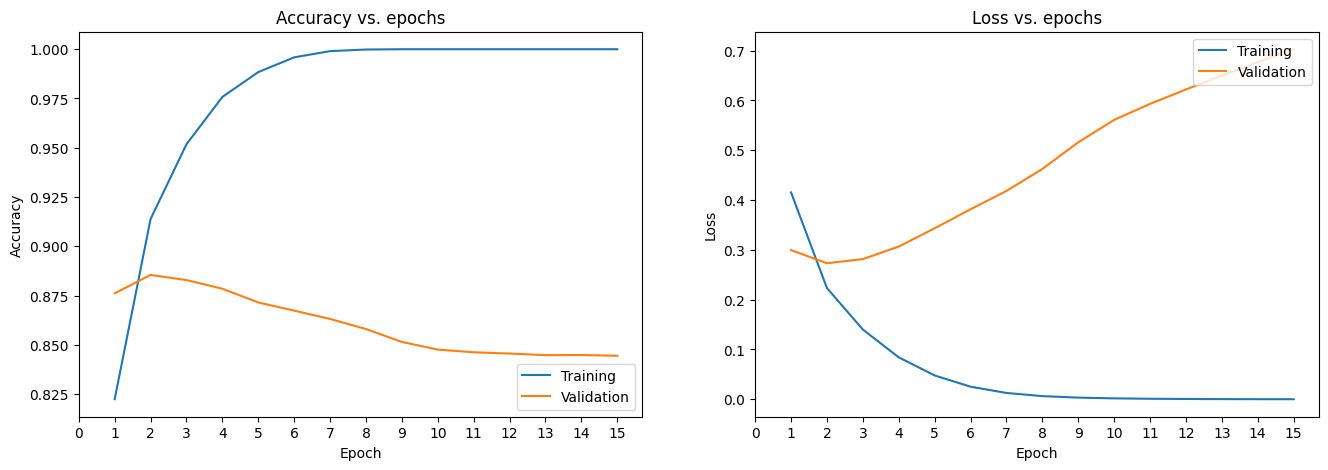

2022-07-18 09:32:00,358: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding1
----------------------------------------evaluate----------------------------------------


2022-07-18 09:32:36,198: INFO: test loss:0.2732
2022-07-18 09:32:36,199: INFO: test accuracy:0.8855
2022-07-18 09:32:36,200: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2022-07-18 09:32:36,201: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2022-07-18 09:32:36,202: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_prepross.generator
2022-07-18 09:32:36,266: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_prepross.generator
2022-07-18 09:32:36,267: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-07-18 09:32:42,264: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 09:32:42,280: INFO: loading layer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl


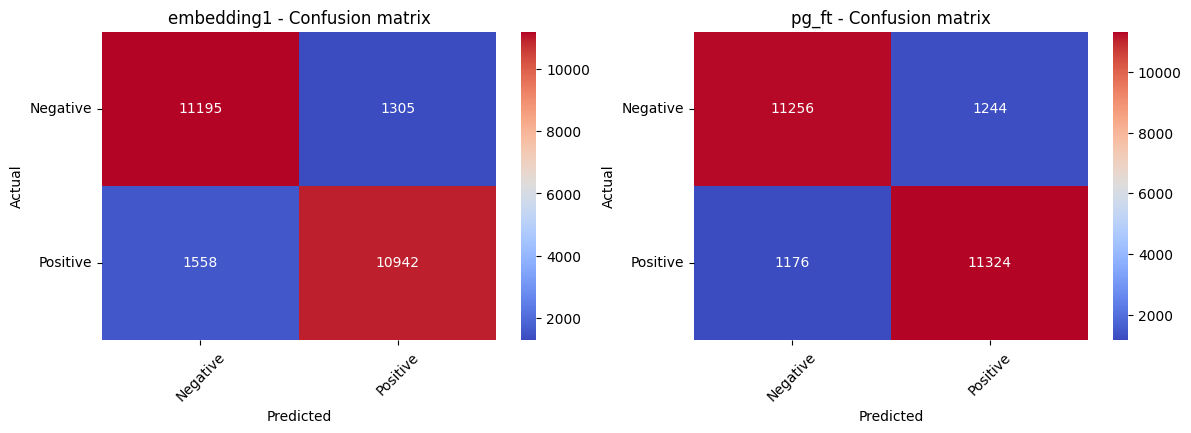

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,pg_ft,imdb_0721_p100.ipynb,6116802,402.5,2022-07-18 09:23,0.1248,0.2414,0.9556,0.9032,0.9904,0.9659
2,mlp2,imdb_0721_p100.ipynb,5120770,83.2,2022-07-18 09:29,0.1467,0.2693,0.9682,0.8965,0.9956,0.9600
3,mlp1,imdb_0721_p100.ipynb,5120770,61.1,2022-07-18 09:26,0.1389,0.2676,0.9546,0.8896,0.9911,0.9563
4,embedding1,imdb_0721_p100.ipynb,4000802,98.3,2022-07-18 09:32,0.1440,0.2732,0.9543,0.8855,0.9899,0.9547
5,pg_default,imdb_0721_p100.ipynb,6184002,390.8,2022-07-18 09:15,0.1502,0.2750,0.9529,0.8853,0.9891,0.9548
6,rnn_lstm_ft,imdb_0721_p100.ipynb,1282802,557.9,2022-07-18 08:55,0.3591,0.3658,0.8550,0.8489,0.9268,0.9248
7,rnn_lstm,imdb_0721_p100.ipynb,5123002,569.9,2022-07-18 08:43,0.6494,0.7105,0.5776,0.5329,0.6319,0.5445


In [36]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets1)
model = qtf.classification.text_models.embedding1(helper, name='embedding1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### embedding2

2022-07-18 09:33:04,703: INFO: model_params.embedding2.dropout=0.4
2022-07-18 09:33:04,704: INFO: model_params.embedding2.embedding_dim=200
2022-07-18 09:33:04,729: INFO: output_bias=[-0.69314718 -0.69314718]
2022-07-18 09:33:04,738: INFO: learning_rate=0.001
2022-07-18 09:33:04,738: INFO: model_params.embedding2.clip_value=None
2022-07-18 09:33:04,744: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding2


TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
Model: "embedding2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 500)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 500, 200)     4000000     ['input_10[0][0]']               
                                                                                                  
 global_average_pooling1d_5 (Gl  (None, 200)         0           ['embedding_7[0][0]']            
 obalAveragePooling1D)                                                                            
                                                                                                  
 global_max_pooling1d_5 (Global  (

2022-07-18 09:33:04,757: INFO: model_params.embedding2.epochs=15
2022-07-18 09:33:04,757: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding2, monitor=val_accuracy)
2022-07-18 09:33:04,758: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-07-18 09:33:04,758: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-07-18 09:33:04,759: INFO: use LearningRateScheduler()
2022-07-18 09:33:04,759: INFO: steps_per_epoch=None
2022-07-18 09:33:04,760: INFO: start training
2022-07-18 09:33:04,760: INFO: use_class_weight=False


Epoch 1/15
774/781 [============================>.] - ETA: 0s - loss: 0.4262 - accuracy: 0.8181INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding2/assets


2022-07-18 09:33:12,218: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding2/assets


781/781 [==============================] - 7s 9ms/step - loss: 0.4245 - accuracy: 0.8189 - val_loss: 0.3117 - val_accuracy: 0.8689 - lr: 0.0010
Epoch 2/15
776/781 [============================>.] - ETA: 0s - loss: 0.2392 - accuracy: 0.9062INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding2/assets


2022-07-18 09:33:19,073: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding2/assets


781/781 [==============================] - 7s 9ms/step - loss: 0.2388 - accuracy: 0.9064 - val_loss: 0.2845 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 3/15
781/781 [==============================] - 6s 8ms/step - loss: 0.1630 - accuracy: 0.9423 - val_loss: 0.2908 - val_accuracy: 0.8795 - lr: 0.0010
Epoch 4/15
781/781 [==============================] - 6s 8ms/step - loss: 0.1097 - accuracy: 0.9654 - val_loss: 0.3117 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 5/15
781/781 [==============================] - 6s 8ms/step - loss: 0.0715 - accuracy: 0.9804 - val_loss: 0.3381 - val_accuracy: 0.8706 - lr: 0.0010
Epoch 6/15
781/781 [==============================] - 6s 8ms/step - loss: 0.0446 - accuracy: 0.9900 - val_loss: 0.3718 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 7/15
781/781 [==============================] - 6s 8ms/step - loss: 0.0264 - accuracy: 0.9957 - val_loss: 0.4123 - val_accuracy: 0.8605 - lr: 0.0010
Epoch 8/15
781/781 [==============================] - 6s 8ms/step - loss: 0.0146 

2022-07-18 09:34:41,043: INFO: finish training [elapsed time: 96.28 seconds]


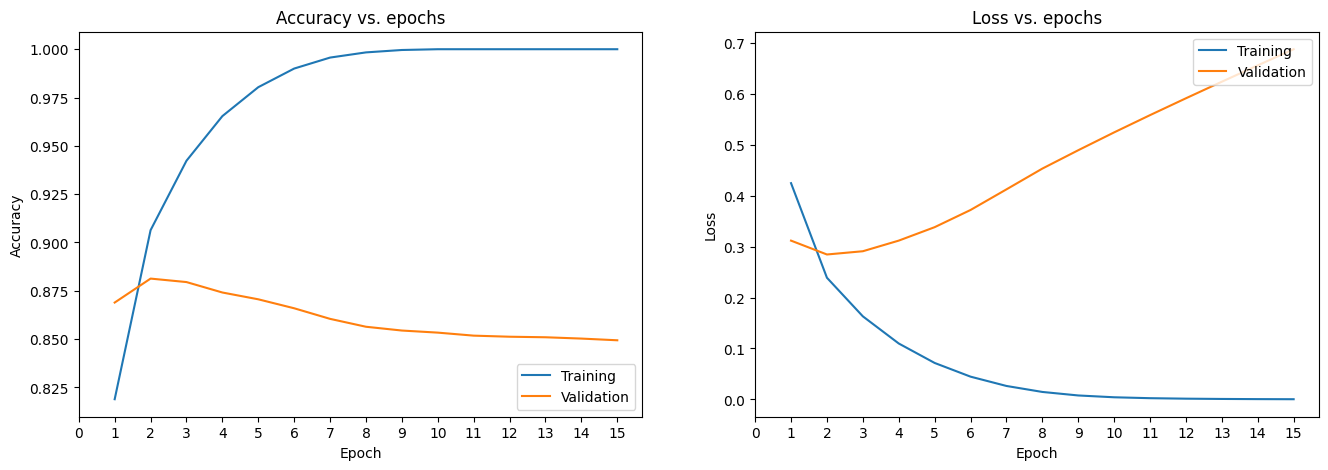

2022-07-18 09:34:41,473: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/embedding2
----------------------------------------evaluate----------------------------------------


2022-07-18 09:35:14,215: INFO: test loss:0.2845
2022-07-18 09:35:14,216: INFO: test accuracy:0.8813
2022-07-18 09:35:14,217: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2022-07-18 09:35:14,218: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2022-07-18 09:35:14,219: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 09:35:14,265: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl
2022-07-18 09:35:14,266: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 09:35:14,267: INFO: loading 

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-07-18 09:35:20,218: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 09:35:20,243: INFO: loading layer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl


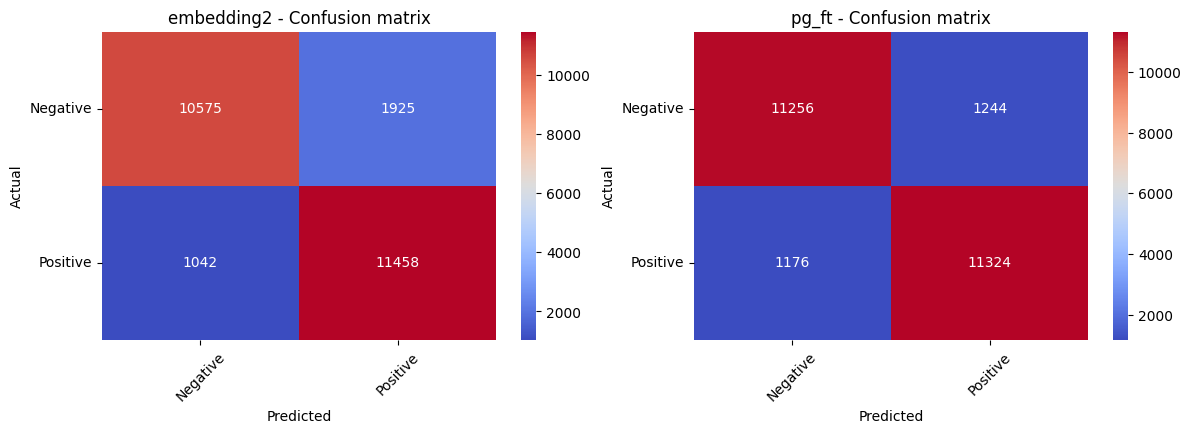

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,pg_ft,imdb_0721_p100.ipynb,6116802,402.5,2022-07-18 09:23,0.1248,0.2414,0.9556,0.9032,0.9904,0.9659
2,mlp2,imdb_0721_p100.ipynb,5120770,83.2,2022-07-18 09:29,0.1467,0.2693,0.9682,0.8965,0.9956,0.9600
3,mlp1,imdb_0721_p100.ipynb,5120770,61.1,2022-07-18 09:26,0.1389,0.2676,0.9546,0.8896,0.9911,0.9563
4,embedding1,imdb_0721_p100.ipynb,4000802,98.3,2022-07-18 09:32,0.1440,0.2732,0.9543,0.8855,0.9899,0.9547
5,pg_default,imdb_0721_p100.ipynb,6184002,390.8,2022-07-18 09:15,0.1502,0.2750,0.9529,0.8853,0.9891,0.9548
6,embedding2,imdb_0721_p100.ipynb,4000802,96.3,2022-07-18 09:35,0.1726,0.2845,0.9396,0.8813,0.9863,0.9528
7,rnn_lstm_ft,imdb_0721_p100.ipynb,1282802,557.9,2022-07-18 08:55,0.3591,0.3658,0.8550,0.8489,0.9268,0.9248
8,rnn_lstm,imdb_0721_p100.ipynb,5123002,569.9,2022-07-18 08:43,0.6494,0.7105,0.5776,0.5329,0.6319,0.5445


In [37]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.embedding1(helper, name='embedding2')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### sepCNN

#### sepcnn

In [64]:
# helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
# model = qtf.classification.models.sepcnn1(helper, name='sepcnn', blocks=1)
# # when bolcks=2, the model can't converg
# model.summary()
# history = helper.train(model)
# helper.model_summary(model, history=history)

#### sepcnn_fasttext

In [65]:
# helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
# model = qtf.classification.models.sepcnn1(helper, name='sepcnn_ft', blocks=1, 
#                    embedding_matrix=embedding_matrix_fasttext,
#                    is_embedding_trainable=False)
# model.summary()
# history = helper.train(model)
# helper.model_summary(model, history=history)

### LSTM

#### rnn_lstm

In [ ]:



ty

#### rnn_lstm_fasttext

2022-07-18 08:44:06,675: INFO: model_params.rnn_lstm_ft.dropout=0.4
2022-07-18 08:44:06,676: INFO: model_params.rnn_lstm_ft.units=200
2022-07-18 08:44:06,676: INFO: max_features=20000
2022-07-18 08:44:06,677: INFO: model_params.rnn_lstm_ft.embedding_dim=200


TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
19776 300


2022-07-18 08:44:07,482: INFO: output_bias=[-0.69314718 -0.69314718]
2022-07-18 08:44:07,490: INFO: learning_rate=0.001
2022-07-18 08:44:07,490: INFO: model_params.rnn_lstm_ft.clip_value=None
2022-07-18 08:44:07,501: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft


Model: "rnn_lstm_ft"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 500, 300)          5932800   
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 400)         801600    
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 200)               480800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 402       
                                                       

2022-07-18 08:44:07,514: INFO: model_params.rnn_lstm_ft.epochs=5
2022-07-18 08:44:07,514: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft, monitor=val_accuracy)
2022-07-18 08:44:07,515: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-07-18 08:44:07,515: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-07-18 08:44:07,516: INFO: use LearningRateScheduler()
2022-07-18 08:44:07,516: INFO: steps_per_epoch=None
2022-07-18 08:44:07,517: INFO: start training
2022-07-18 08:44:07,518: INFO: use_class_weight=False


Epoch 1/5
781/781 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.5091

2022-07-18 08:46:02,440: WARNING: Found untraced functions such as lstm_cell_11_layer_call_fn, lstm_cell_11_layer_call_and_return_conditional_losses, lstm_cell_9_layer_call_fn, lstm_cell_9_layer_call_and_return_conditional_losses, lstm_cell_10_layer_call_fn while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft/assets


2022-07-18 08:46:05,392: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft/assets
2022-07-18 08:46:05,814: WARNING: <keras.layers.recurrent.LSTMCell object at 0x7f0d90b60dc0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-07-18 08:46:05,815: WARNING: <keras.layers.recurrent.LSTMCell object at 0x7f0d8fccadf0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-07-18 08:46:05,816: WARNING: <keras.layers.recurre

781/781 [==============================] - 118s 146ms/step - loss: 0.6943 - accuracy: 0.5091 - val_loss: 0.7005 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/5
781/781 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.4968

2022-07-18 08:47:57,030: WARNING: Found untraced functions such as lstm_cell_11_layer_call_fn, lstm_cell_11_layer_call_and_return_conditional_losses, lstm_cell_9_layer_call_fn, lstm_cell_9_layer_call_and_return_conditional_losses, lstm_cell_10_layer_call_fn while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft/assets


2022-07-18 08:47:59,868: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft/assets
2022-07-18 08:48:00,299: WARNING: <keras.layers.recurrent.LSTMCell object at 0x7f0d90b60dc0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-07-18 08:48:00,301: WARNING: <keras.layers.recurrent.LSTMCell object at 0x7f0d8fccadf0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-07-18 08:48:00,302: WARNING: <keras.layers.recurre

781/781 [==============================] - 114s 147ms/step - loss: 0.6948 - accuracy: 0.4968 - val_loss: 0.6930 - val_accuracy: 0.5020 - lr: 0.0010
Epoch 3/5
781/781 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5083

2022-07-18 08:49:50,247: WARNING: Found untraced functions such as lstm_cell_11_layer_call_fn, lstm_cell_11_layer_call_and_return_conditional_losses, lstm_cell_9_layer_call_fn, lstm_cell_9_layer_call_and_return_conditional_losses, lstm_cell_10_layer_call_fn while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft/assets


2022-07-18 08:49:53,063: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft/assets
2022-07-18 08:49:53,488: WARNING: <keras.layers.recurrent.LSTMCell object at 0x7f0d90b60dc0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-07-18 08:49:53,489: WARNING: <keras.layers.recurrent.LSTMCell object at 0x7f0d8fccadf0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-07-18 08:49:53,490: WARNING: <keras.layers.recurre

781/781 [==============================] - 113s 145ms/step - loss: 0.6926 - accuracy: 0.5083 - val_loss: 0.6921 - val_accuracy: 0.5070 - lr: 0.0010
Epoch 4/5
781/781 [==============================] - 98s 126ms/step - loss: 0.6905 - accuracy: 0.5124 - val_loss: 0.6928 - val_accuracy: 0.5020 - lr: 0.0010
Epoch 5/5
781/781 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.6071

2022-07-18 08:53:22,059: WARNING: Found untraced functions such as lstm_cell_11_layer_call_fn, lstm_cell_11_layer_call_and_return_conditional_losses, lstm_cell_9_layer_call_fn, lstm_cell_9_layer_call_and_return_conditional_losses, lstm_cell_10_layer_call_fn while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft/assets


2022-07-18 08:53:24,942: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft/assets
2022-07-18 08:53:25,371: WARNING: <keras.layers.recurrent.LSTMCell object at 0x7f0d90b60dc0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-07-18 08:53:25,372: WARNING: <keras.layers.recurrent.LSTMCell object at 0x7f0d8fccadf0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-07-18 08:53:25,373: WARNING: <keras.layers.recurre

781/781 [==============================] - 114s 145ms/step - loss: 0.6216 - accuracy: 0.6071 - val_loss: 0.3658 - val_accuracy: 0.8489 - lr: 0.0010


2022-07-18 08:53:25,393: INFO: finish training [elapsed time: 557.88 seconds]


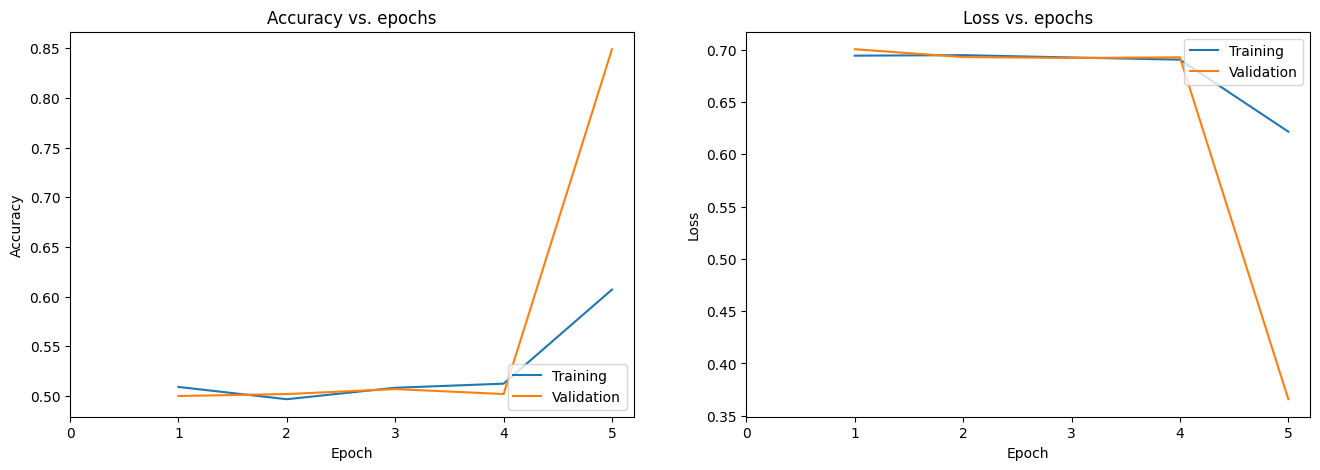

2022-07-18 08:53:25,722: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/rnn_lstm_ft
----------------------------------------evaluate----------------------------------------


2022-07-18 08:55:19,879: INFO: test loss:0.3658
2022-07-18 08:55:19,880: INFO: test accuracy:0.8489
2022-07-18 08:55:19,881: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2022-07-18 08:55:19,883: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2022-07-18 08:55:19,883: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 08:55:19,927: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl
2022-07-18 08:55:19,928: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 08:55:19,929: INFO: loading 

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-07-18 08:55:29,476: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 08:55:29,506: INFO: loading layer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl


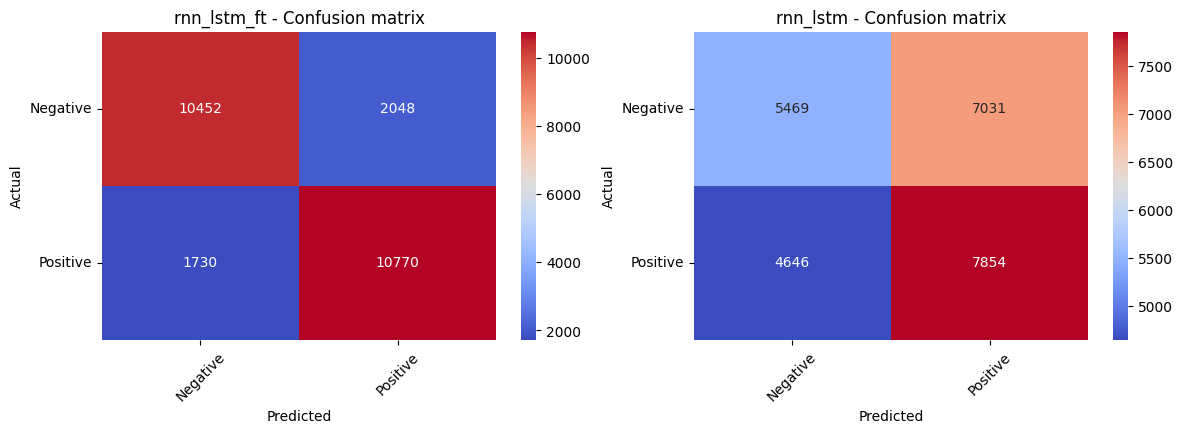

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,rnn_lstm_ft,imdb_0721_p100.ipynb,1282802,557.9,2022-07-18 08:55,0.3591,0.3658,0.8550,0.8489,0.9268,0.9248
2,rnn_lstm,imdb_0721_p100.ipynb,5123002,569.9,2022-07-18 08:43,0.6494,0.7105,0.5776,0.5329,0.6319,0.5445


In [27]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.lstm1(helper, name='rnn_lstm_ft',
                 embedding_matrix=embedding_matrix_fasttext,
                 is_embedding_trainable=False,
                 mask_zero=False)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### Pooled GRU 

#### pg_default

2022-07-18 09:07:52,282: INFO: model_params.pg_default.dropout=0.4
2022-07-18 09:07:52,282: INFO: model_params.pg_default.learning_rate=0.0005
2022-07-18 09:07:52,283: INFO: model_params.pg_default.clip_value=None
2022-07-18 09:07:52,284: INFO: batch_size=32
2022-07-18 09:07:52,284: INFO: max_features=20000
2022-07-18 09:07:52,285: INFO: model_params.pg_default.embedding_dim=300
2022-07-18 09:07:52,756: INFO: output_bias=[-0.69314718 -0.69314718]
2022-07-18 09:07:52,764: INFO: model_params.pg_default.clip_value=None
2022-07-18 09:07:52,769: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default


Model: "pg_default"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 500, 300)     6000000     ['input_5[0][0]']                
                                                                                                  
 spatial_dropout1d_2 (SpatialDr  (None, 500, 300)    0           ['embedding_4[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 500, 160)    183360      ['spatial_dropout1d_2[0]

2022-07-18 09:07:52,786: INFO: model_params.pg_default.epochs=10
2022-07-18 09:07:52,787: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default, monitor=val_accuracy)
2022-07-18 09:07:52,788: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-07-18 09:07:52,788: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-07-18 09:07:52,789: INFO: use LearningRateScheduler()
2022-07-18 09:07:52,789: INFO: steps_per_epoch=None
2022-07-18 09:07:52,790: INFO: start training
2022-07-18 09:07:52,790: INFO: use_class_weight=False


Epoch 00001: Still keep learning rate 0.0005 instead of 0.001
Epoch 1/10
781/781 [==============================] - ETA: 0s - loss: 0.4130 - accuracy: 0.8050

2022-07-18 09:08:41,622: WARNING: Found untraced functions such as gru_cell_7_layer_call_fn, gru_cell_7_layer_call_and_return_conditional_losses, gru_cell_8_layer_call_fn, gru_cell_8_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default/assets


2022-07-18 09:08:43,685: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default/assets
2022-07-18 09:08:43,989: WARNING: <keras.layers.recurrent.GRUCell object at 0x7f0d892e7b50> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-07-18 09:08:43,991: WARNING: <keras.layers.recurrent.GRUCell object at 0x7f0d892e6070> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.


781/781 [==============================] - 51s 62ms/step - loss: 0.4130 - accuracy: 0.8050 - val_loss: 0.2800 - val_accuracy: 0.8818 - lr: 5.0000e-04
Epoch 00002: Still keep learning rate 0.0005 instead of 0.001
Epoch 2/10
781/781 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.9142

2022-07-18 09:09:28,580: WARNING: Found untraced functions such as gru_cell_7_layer_call_fn, gru_cell_7_layer_call_and_return_conditional_losses, gru_cell_8_layer_call_fn, gru_cell_8_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default/assets


2022-07-18 09:09:30,668: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default/assets
2022-07-18 09:09:30,965: WARNING: <keras.layers.recurrent.GRUCell object at 0x7f0d892e7b50> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-07-18 09:09:30,966: WARNING: <keras.layers.recurrent.GRUCell object at 0x7f0d892e6070> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.


781/781 [==============================] - 47s 60ms/step - loss: 0.2174 - accuracy: 0.9142 - val_loss: 0.2750 - val_accuracy: 0.8853 - lr: 5.0000e-04
Epoch 00003: Still keep learning rate 0.0005 instead of 0.001
Epoch 3/10
781/781 [==============================] - 37s 47ms/step - loss: 0.1492 - accuracy: 0.9445 - val_loss: 0.2932 - val_accuracy: 0.8825 - lr: 5.0000e-04
Epoch 00004: Still keep learning rate 0.0005 instead of 0.001
Epoch 4/10
781/781 [==============================] - 36s 47ms/step - loss: 0.1007 - accuracy: 0.9653 - val_loss: 0.3572 - val_accuracy: 0.8720 - lr: 5.0000e-04
Epoch 00005: Still keep learning rate 0.0005 instead of 0.001
Epoch 5/10
781/781 [==============================] - 37s 47ms/step - loss: 0.0649 - accuracy: 0.9794 - val_loss: 0.3938 - val_accuracy: 0.8735 - lr: 5.0000e-04
Epoch 00006: Still keep learning rate 0.0005 instead of 0.001
Epoch 6/10
781/781 [==============================] - 37s 47ms/step - loss: 0.0449 - accuracy: 0.9849 - val_loss: 0.592

2022-07-18 09:14:23,562: INFO: finish training [elapsed time: 390.77 seconds]


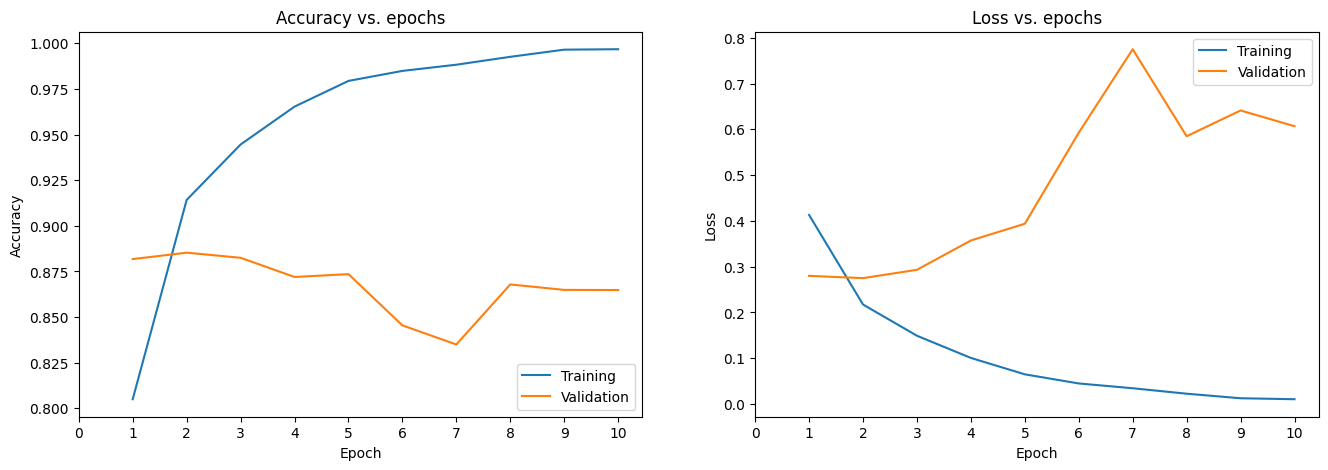

2022-07-18 09:14:23,954: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default
----------------------------------------evaluate----------------------------------------


2022-07-18 09:15:18,488: INFO: test loss:0.2750
2022-07-18 09:15:18,489: INFO: test accuracy:0.8853
2022-07-18 09:15:18,490: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2022-07-18 09:15:18,492: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2022-07-18 09:15:18,492: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 09:15:18,535: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl
2022-07-18 09:15:18,536: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 09:15:18,536: INFO: loading 

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-07-18 09:15:27,972: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 09:15:28,000: INFO: loading layer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl


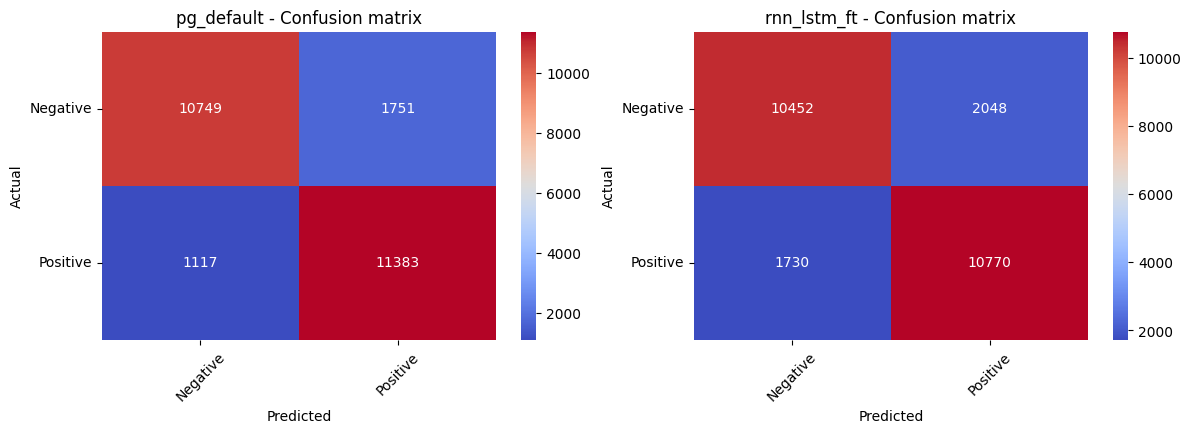

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,pg_default,imdb_0721_p100.ipynb,6184002,390.8,2022-07-18 09:15,0.1502,0.2750,0.9529,0.8853,0.9891,0.9548
2,rnn_lstm_ft,imdb_0721_p100.ipynb,1282802,557.9,2022-07-18 08:55,0.3591,0.3658,0.8550,0.8489,0.9268,0.9248
3,rnn_lstm,imdb_0721_p100.ipynb,5123002,569.9,2022-07-18 08:43,0.6494,0.7105,0.5776,0.5329,0.6319,0.5445


In [32]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.pooled_gru1(helper, name='pg_default', is_embedding_trainable=True)
model.summary()
history = helper.train(model) 
helper.model_summary(model, history=history)

#### pg_fasttext

2022-07-18 09:16:06,368: INFO: model_params.pg_ft.dropout=0.4
2022-07-18 09:16:06,369: INFO: model_params.pg_ft.learning_rate=0.0005
2022-07-18 09:16:06,369: INFO: model_params.pg_ft.clip_value=None
2022-07-18 09:16:06,370: INFO: batch_size=32
2022-07-18 09:16:06,370: INFO: max_features=20000
2022-07-18 09:16:06,371: INFO: model_params.pg_ft.embedding_dim=300
2022-07-18 09:16:06,858: INFO: output_bias=[-0.69314718 -0.69314718]
2022-07-18 09:16:06,867: INFO: model_params.pg_ft.clip_value=None
2022-07-18 09:16:06,872: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft


Model: "pg_ft"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 500, 300)     5932800     ['input_6[0][0]']                
                                                                                                  
 spatial_dropout1d_3 (SpatialDr  (None, 500, 300)    0           ['embedding_5[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 500, 160)    183360      ['spatial_dropout1d_3[0][0]']

2022-07-18 09:16:06,890: INFO: model_params.pg_ft.epochs=10
2022-07-18 09:16:06,891: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft, monitor=val_accuracy)
2022-07-18 09:16:06,891: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-07-18 09:16:06,892: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-07-18 09:16:06,892: INFO: use LearningRateScheduler()
2022-07-18 09:16:06,893: INFO: steps_per_epoch=None
2022-07-18 09:16:06,894: INFO: start training
2022-07-18 09:16:06,894: INFO: use_class_weight=False


Epoch 00001: Still keep learning rate 0.0005 instead of 0.001
Epoch 1/10
781/781 [==============================] - ETA: 0s - loss: 0.3888 - accuracy: 0.8224

2022-07-18 09:16:56,673: WARNING: Found untraced functions such as gru_cell_13_layer_call_fn, gru_cell_13_layer_call_and_return_conditional_losses, gru_cell_14_layer_call_fn, gru_cell_14_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft/assets


2022-07-18 09:16:58,720: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft/assets
2022-07-18 09:16:59,020: WARNING: <keras.layers.recurrent.GRUCell object at 0x7f0c6a3f2f70> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-07-18 09:16:59,021: WARNING: <keras.layers.recurrent.GRUCell object at 0x7f0c6a3e5dc0> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.


781/781 [==============================] - 52s 63ms/step - loss: 0.3888 - accuracy: 0.8224 - val_loss: 0.2679 - val_accuracy: 0.8869 - lr: 5.0000e-04
Epoch 00002: Still keep learning rate 0.0005 instead of 0.001
Epoch 2/10
781/781 [==============================] - ETA: 0s - loss: 0.2460 - accuracy: 0.9005

2022-07-18 09:17:43,958: WARNING: Found untraced functions such as gru_cell_13_layer_call_fn, gru_cell_13_layer_call_and_return_conditional_losses, gru_cell_14_layer_call_fn, gru_cell_14_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft/assets


2022-07-18 09:17:45,966: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft/assets
2022-07-18 09:17:46,260: WARNING: <keras.layers.recurrent.GRUCell object at 0x7f0c6a3f2f70> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-07-18 09:17:46,261: WARNING: <keras.layers.recurrent.GRUCell object at 0x7f0c6a3e5dc0> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.


781/781 [==============================] - 47s 60ms/step - loss: 0.2460 - accuracy: 0.9005 - val_loss: 0.2411 - val_accuracy: 0.9002 - lr: 5.0000e-04
Epoch 00003: Still keep learning rate 0.0005 instead of 0.001
Epoch 3/10
781/781 [==============================] - ETA: 0s - loss: 0.1934 - accuracy: 0.9247

2022-07-18 09:18:32,585: WARNING: Found untraced functions such as gru_cell_13_layer_call_fn, gru_cell_13_layer_call_and_return_conditional_losses, gru_cell_14_layer_call_fn, gru_cell_14_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft/assets


2022-07-18 09:18:34,635: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft/assets
2022-07-18 09:18:34,936: WARNING: <keras.layers.recurrent.GRUCell object at 0x7f0c6a3f2f70> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-07-18 09:18:34,937: WARNING: <keras.layers.recurrent.GRUCell object at 0x7f0c6a3e5dc0> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.


781/781 [==============================] - 49s 62ms/step - loss: 0.1934 - accuracy: 0.9247 - val_loss: 0.2414 - val_accuracy: 0.9032 - lr: 5.0000e-04
Epoch 00004: Still keep learning rate 0.0005 instead of 0.001
Epoch 4/10
781/781 [==============================] - 36s 46ms/step - loss: 0.1548 - accuracy: 0.9405 - val_loss: 0.2623 - val_accuracy: 0.9001 - lr: 5.0000e-04
Epoch 00005: Still keep learning rate 0.0005 instead of 0.001
Epoch 5/10
781/781 [==============================] - 36s 47ms/step - loss: 0.1208 - accuracy: 0.9554 - val_loss: 0.2936 - val_accuracy: 0.8966 - lr: 5.0000e-04
Epoch 00006: Still keep learning rate 0.0005 instead of 0.001
Epoch 6/10
781/781 [==============================] - 36s 46ms/step - loss: 0.0945 - accuracy: 0.9656 - val_loss: 0.3408 - val_accuracy: 0.8896 - lr: 5.0000e-04
Epoch 00007: Still keep learning rate 0.0005 instead of 0.001
Epoch 7/10
781/781 [==============================] - 36s 47ms/step - loss: 0.0710 - accuracy: 0.9750 - val_loss: 0.430

2022-07-18 09:22:49,412: INFO: finish training [elapsed time: 402.52 seconds]


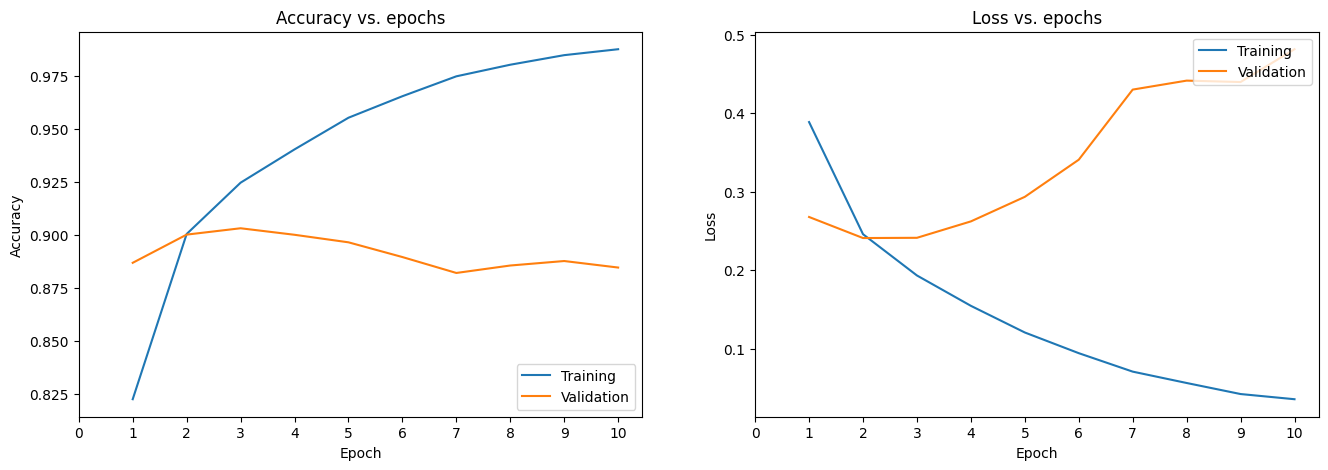

2022-07-18 09:22:49,771: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft
----------------------------------------evaluate----------------------------------------


2022-07-18 09:23:41,616: INFO: test loss:0.2414
2022-07-18 09:23:41,616: INFO: test accuracy:0.9032
2022-07-18 09:23:41,618: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2022-07-18 09:23:41,619: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2022-07-18 09:23:41,620: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 09:23:41,663: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl
2022-07-18 09:23:41,664: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 09:23:41,665: INFO: loading 

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-07-18 09:23:48,776: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 09:23:48,789: INFO: loading layer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl


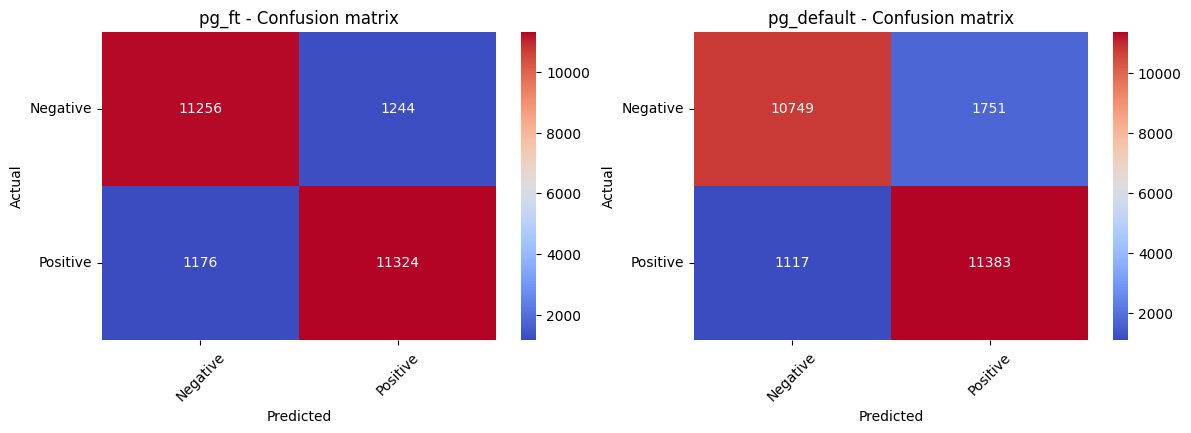

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,pg_ft,imdb_0721_p100.ipynb,6116802,402.5,2022-07-18 09:23,0.1248,0.2414,0.9556,0.9032,0.9904,0.9659
2,pg_default,imdb_0721_p100.ipynb,6184002,390.8,2022-07-18 09:15,0.1502,0.2750,0.9529,0.8853,0.9891,0.9548
3,rnn_lstm_ft,imdb_0721_p100.ipynb,1282802,557.9,2022-07-18 08:55,0.3591,0.3658,0.8550,0.8489,0.9268,0.9248
4,rnn_lstm,imdb_0721_p100.ipynb,5123002,569.9,2022-07-18 08:43,0.6494,0.7105,0.5776,0.5329,0.6319,0.5445


In [33]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.pooled_gru1(helper, name='pg_ft', 
                       embedding_matrix=embedding_matrix_fasttext, 
                       is_embedding_trainable=True)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### bert

In [61]:
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

In [62]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [63]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [64]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.99280983 -0.18611865  0.3667382   0.15233754  0.6550446
  0.9681154  -0.948627    0.00216129 -0.9877731   0.06842719 -0.9763059 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2894631   0.3432125   0.33231503 ...  0.21300879  0.71020824
  -0.05771083]
 [-0.28741956  0.31981033 -0.23018478 ...  0.58455044 -0.21329702
   0.72692096]
 [-0.66156983  0.68876874 -0.87432986 ...  0.10877332 -0.26173213
   0.4785546 ]
 ...
 [-0.22561109 -0.2892557  -0.07064363 ...  0.47566098  0.8327722
   0.40025353]
 [-0.29824188 -0.27473086 -0.05450502 ...  0.48849785  1.0955354
   0.18163365]
 [-0.4437817   0.00930776  0.07223777 ...  0.17290121  1.1833248
   0.07898013]]


####  bert1

In [65]:
train_ds = raw_datasets.train_dataset
for text_batch, label_batch in train_ds.take(1):
    print(text_batch.shape) 
    for i in range(3):
        print(f'Review: {text_batch[i]}, type(text_batch):{type(text_batch)}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({params.classes[label]})')

(32,)
Review: b'what if somerset maugham had written a novel about a coal miner who decided to search for transcendental enlightenment by trying to join a country club ? if he had , he could have called it the razor s edge , since the katha-upanishad tells us , the sharp edge of a razor is difficult to pass over thus the wise say the path to salvation is hard . but maugham decided to stick with the well-bred class , and so we have darryl f . zanuck s version of larry darrell , recently returned from wwi , carefully groomed , well connected in society and determined to find himself by becoming a coal miner . br br or , as maugham tells us , this is the young man of whom i write . he is not famous . it may be that when at last his life comes to an end he will leave no more trace of his sojourn on this earth than a stone thrown into a river leaves on the surface of the water . yet it may be that the way of life he has chosen for himself may have an ever growing influence over his fellow m

In [66]:
tf.data.experimental.cardinality(helper.datasets.train_dataset).numpy() 

781

In [67]:
helper.params.metrics 

['accuracy']

In [72]:
def compile1(model, helper):
    epochs = 5
    steps_per_epoch = tf.data.experimental.cardinality(helper.datasets.train_dataset).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')
    loss = losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer,
                  loss=loss,
                  metrics=helper.params.metrics)
    if helper.params.use_savedmodel:
        model.checkpoint_path = os.path.join(helper.params.program_path, model.name)
    else:
        model.checkpoint_path = os.path.join(helper.params.program_path, model.name+'.h5')
    return model



In [76]:
def get_bert1(helper,
              name='bert_simple',
              dropout=None,
              last_activation=None,
              learning_rate=None,
              clip_value=None,
              batch_size=None,
              binary_flag=False):

    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')
    if learning_rate is None:
        learning_rate = helper.params.get_model_param(name, 'learning_rate')
    if clip_value is None:
        clip_value = helper.params.get_model_param(name, 'clip_value')        
    if batch_size is None:
        batch_size = helper.params.get_model_param(name, 'batch_size')

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    x = outputs['pooled_output']
    x = layers.Dropout(dropout)(x)
    dense_unit = 1 if binary_flag else len(helper.params.classes)
    x = helper.get_dense_layer(dense_unit, activation=last_activation)(x)
    model = Model(inputs=text_input, outputs=x, name=name)
    compile1(model, helper)
#     helper.compile(model, learning_rate=learning_rate, clip_value=clip_value)  
# helper.datasets = helper.datasets.batch(batch_size)
    return model

helper = qtf.classification.Classification(params, model_results=model_results, datasets=raw_datasets)
model = get_bert1(helper, name='bert_simple1', learning_rate=3e-5)
model.summary()
history = helper.train(model) 
helper.model_summary(model, history=history)  

2022-07-20 02:31:03,642: INFO: dropout=0.1
2022-07-20 02:31:03,643: INFO: model_params.bert_simple1.clip_value=None
2022-07-20 02:31:03,644: INFO: batch_size=32
2022-07-20 02:31:14,724: INFO: output_bias=[-0.69314718 -0.69314718]
2022-07-20 02:31:14,734: INFO: using Adamw optimizer
2022-07-20 02:31:14,735: INFO: gradient_clip_norm=1.000000


Model: "bert_simple1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                           

2022-07-20 02:31:14,778: INFO: epochs=3
2022-07-20 02:31:14,779: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/bert_simple1, monitor=val_accuracy)
2022-07-20 02:31:14,780: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-07-20 02:31:14,780: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-07-20 02:31:14,781: INFO: steps_per_epoch=None
2022-07-20 02:31:14,782: INFO: start training
2022-07-20 02:31:14,783: INFO: use_class_weight=False


Epoch 1/3
781/781 [==============================] - ETA: 0s - loss: 0.4810 - accuracy: 0.7639

2022-07-20 02:35:47,936: WARNING: Found untraced functions such as restored_function_body, restored_function_body, restored_function_body, restored_function_body, restored_function_body while saving (showing 5 of 124). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/bert_simple1/assets


2022-07-20 02:35:53,134: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/bert_simple1/assets
2022-07-20 02:35:53,679: INFO: finish training [elapsed time: 278.90 seconds]


TypeError: unsupported operand type(s) for *: 'WarmUp' and 'int'

#### bert2 

2022-07-19 05:39:28,398: INFO: dropout=0.1
2022-07-19 05:39:28,399: INFO: model_params.bert2.clip_value=None
2022-07-19 05:39:28,399: INFO: batch_size=32
2022-07-19 05:39:41,704: INFO: output_bias=[-0.69314718 -0.69314718]
2022-07-19 05:39:41,713: INFO: model_params.bert2.clip_value=None
2022-07-19 05:39:41,718: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/bert2


Model: "bert2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

2022-07-19 05:39:41,748: INFO: epochs=3
2022-07-19 05:39:41,748: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/bert2, monitor=val_accuracy)
2022-07-19 05:39:41,749: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-07-19 05:39:41,750: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-07-19 05:39:41,750: INFO: use LearningRateScheduler()
2022-07-19 05:39:41,751: INFO: steps_per_epoch=None
2022-07-19 05:39:41,751: INFO: start training
2022-07-19 05:39:41,752: INFO: use_class_weight=False


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001 from 3e-05.
Epoch 1/3
781/781 [==============================] - ETA: 0s - loss: 0.7129 - accuracy: 0.4971

2022-07-19 05:44:28,559: WARNING: Found untraced functions such as gru_cell_10_layer_call_fn, gru_cell_10_layer_call_and_return_conditional_losses, gru_cell_11_layer_call_fn, gru_cell_11_layer_call_and_return_conditional_losses, restored_function_body while saving (showing 5 of 128). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/bert2/assets


2022-07-19 05:44:37,997: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/bert2/assets
2022-07-19 05:44:38,934: WARNING: <keras.layers.recurrent.GRUCell object at 0x7f01a4dc5700> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
2022-07-19 05:44:38,935: WARNING: <keras.layers.recurrent.GRUCell object at 0x7f01a4d8f8b0> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.


781/781 [==============================] - 297s 370ms/step - loss: 0.7129 - accuracy: 0.4971 - val_loss: 0.7043 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/3
781/781 [==============================] - 268s 343ms/step - loss: 0.7009 - accuracy: 0.5025 - val_loss: 0.7049 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/3
781/781 [==============================] - 268s 343ms/step - loss: 0.7008 - accuracy: 0.5014 - val_loss: 0.7043 - val_accuracy: 0.5000 - lr: 0.0010


2022-07-19 05:53:34,342: INFO: finish training [elapsed time: 832.59 seconds]


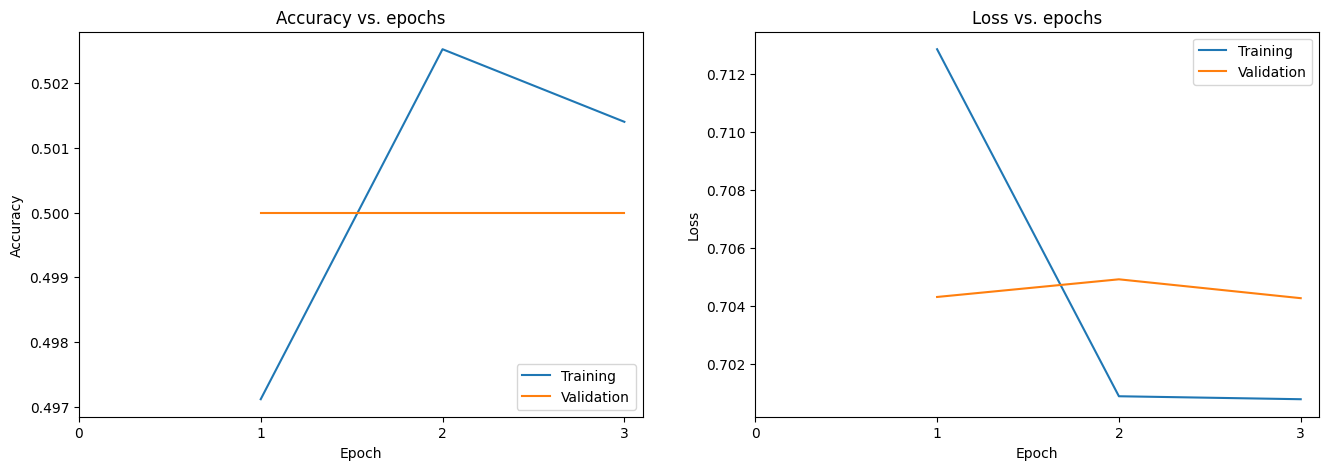

2022-07-19 05:53:34,634: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/bert2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/bert2
----------------------------------------evaluate----------------------------------------


2022-07-19 06:00:13,544: INFO: test loss:0.7043
2022-07-19 06:00:13,544: INFO: test accuracy:0.5000
2022-07-19 06:00:13,547: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2022-07-19 06:00:13,549: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2022-07-19 06:00:13,550: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/raw_preprocess.generator
2022-07-19 06:00:13,551: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/raw_preprocess.generator
2022-07-19 06:00:13,551: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-07-19 06:00:25,301: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-19 06:00:25,307: INFO: loading layer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl


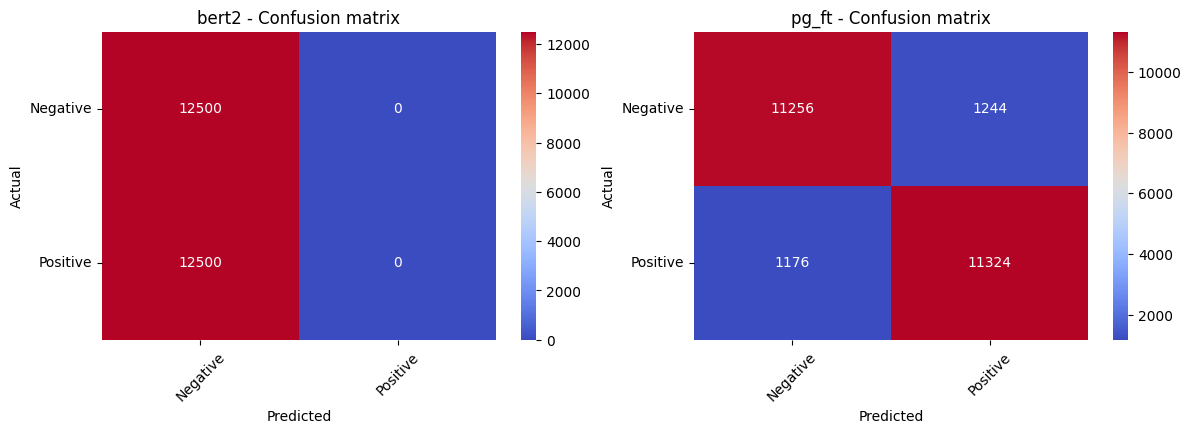

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,pg_ft,imdb_0721_p100.ipynb,6116802,402.5,2022-07-18 09:23,0.1248,0.2414,0.9556,0.9032,0.9904,0.9659
2,mlp2,imdb_0721_p100.ipynb,5120770,83.2,2022-07-18 09:29,0.1467,0.2693,0.9682,0.8965,0.9956,0.9600
3,mlp1,imdb_0721_p100.ipynb,5120770,61.1,2022-07-18 09:26,0.1389,0.2676,0.9546,0.8896,0.9911,0.9563
4,embedding1,imdb_0721_p100.ipynb,4000802,98.3,2022-07-18 09:32,0.1440,0.2732,0.9543,0.8855,0.9899,0.9547
5,pg_default,imdb_0721_p100.ipynb,6184002,390.8,2022-07-18 09:15,0.1502,0.2750,0.9529,0.8853,0.9891,0.9548
6,embedding2,imdb_0721_p100.ipynb,4000802,96.3,2022-07-18 09:35,0.1726,0.2845,0.9396,0.8813,0.9863,0.9528
7,rnn_lstm_ft,imdb_0721_p100.ipynb,1282802,557.9,2022-07-18 08:55,0.3591,0.3658,0.8550,0.8489,0.9268,0.9248
8,rnn_lstm,imdb_0721_p100.ipynb,5123002,569.9,2022-07-18 08:43,0.6494,0.7105,0.5776,0.5329,0.6319,0.5445
9,bert_simple1,imdb_0721_p100.ipynb,28764674,779.6,2022-07-19 04:57,0.6932,0.6932,0.5000,0.5000,0.4823,0.4890
10,bert2,imdb_0721_p100.ipynb,29049410,832.6,2022-07-19 06:00,0.7043,0.7043,0.5000,0.5000,0.3607,0.3702


In [71]:
def get_bert2(helper,
                name='pg',
                dropout=None,
                is_embedding_trainable=False,
                embedding_matrix=None,
                mask_zero=False,
                last_activation=None,
                dense_layer_count=0,
                dense_layer_units=64,
                use_bn=False,
                learning_rate=None,
                clip_value=None,
                rnn_layer_count=0,
                rnn_layer_units=80,
                batch_size=None,
                binary_flag=False):

    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')
    if rnn_layer_units is None:
        rnn_layer_units = helper.params.get_model_param(name, 'units')
    if learning_rate is None:
        learning_rate = helper.params.get_model_param(name, 'learning_rate')
    if clip_value is None:
        clip_value = helper.params.get_model_param(name, 'clip_value')
    if batch_size is None:
        batch_size = helper.params.get_model_param(name, 'batch_size')

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    x = outputs['sequence_output']
    
    if dropout > 0:
        x = layers.SpatialDropout1D(dropout)(x)
    x = layers.Bidirectional(layers.GRU(rnn_layer_units, return_sequences=True))(x)
    for i in range(rnn_layer_count):
        x = layers.GRU(rnn_layer_units, return_sequences=True)(x)

    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.concatenate([avg_pool, max_pool])
    for i in range(dense_layer_count):
        if use_bn:
            x = layers.BatchNormalization()(x)
        x = layers.Dense(dense_layer_units, activation='relu')(x)
        if dropout > 0:
            x = layers.Dropout(dropout)(x)

    dense_unit = 1 if binary_flag else len(helper.params.classes)
    x = helper.get_dense_layer(dense_unit, activation=last_activation)(x)
    model = Model(inputs=text_input, outputs=x, name=name)
    helper.compile(model, learning_rate=learning_rate, clip_value=clip_value)
    helper.datasets = helper.datasets.batch(batch_size)
    return model

helper = qtf.classification.Classification(params, model_results=model_results, datasets=raw_datasets)
model = get_bert2(helper, name='bert2', learning_rate=3e-5)
model.summary()
history = helper.train(model) 
helper.model_summary(model, history=history)

## 评估

### 最佳模型

In [38]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10, columns=['program_name', 'model_name', 'create_time', 'test_loss', 'test_accuracy'])

2022-07-18 09:35:40,942: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb
2022-07-18 09:35:40,943: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json


,program_name,model_name,create_time,test_loss,test_accuracy
1,imdb_0721_p100.ipynb,pg_ft,2022-07-18 09:23,0.2414,0.9032
2,imdb_0721_p100.ipynb,mlp2,2022-07-18 09:29,0.2693,0.8965
3,imdb_0721_p100.ipynb,mlp1,2022-07-18 09:26,0.2676,0.8896
4,imdb_0721_p100.ipynb,embedding1,2022-07-18 09:32,0.2732,0.8855
5,imdb_0721_p100.ipynb,pg_default,2022-07-18 09:15,0.2750,0.8853
6,imdb_0721_p100.ipynb,embedding2,2022-07-18 09:35,0.2845,0.8813
7,imdb_0721_p100.ipynb,rnn_lstm_ft,2022-07-18 08:55,0.3658,0.8489
8,imdb_0721_p100.ipynb,rnn_lstm,2022-07-18 08:43,0.7105,0.5329


In [39]:
predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
print(len(helper.datasets.train_data), len(helper.datasets.train_labels))
print(helper.datasets.train_data[0:2])
print(helper.datasets.train_labels[0:2])

predictor = predictors[0]
train_result = predictor.evaluate(helper.datasets.train_data, helper.datasets.train_labels)
train_result

2022-07-18 09:35:41,018: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_ft
2022-07-18 09:35:48,180: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2022-07-18 09:35:48,186: INFO: loading layer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl
2022-07-18 09:35:48,375: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2
2022-07-18 09:35:48,699: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_map.generator
2022-07-18 09:35:48,701: INFO: loading layer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/

25000 25000
["POSSIBLE SPOILERS<br /><br />The Spy Who Shagged Me is a muchly overrated and over-hyped sequel. International Man of Mystery came straight out of the blue. It was a lone star that few people had heard of. But it was stunningly original, had sophisticated humour and ample humour, always kept in good taste, and had a brilliant cast. The Spy Who Shagged Me was a lot more commercially advertised and hyped about.<br /><br />OK I'll admit, the first time I saw this film I thought it was very funny, but it's only after watching it two or three times that you see all the flaws. The acting was OK, but Heather Graham cannot act. Her performance didn't seem very convincing and she wasn't near as good as Liz Hurley was in the first one. Those characters who bloomed in the first one, (Scott Evil, Number 2 etc.) are thrown into the background hear and don't get many stand-alone scenes. The film is simply overrun with cameos.<br /><br />In particular, I hated the way they totally disre

{'loss': 0.12478357553482056, 'accuracy': 0.9556400179862976}

In [40]:
for predictor in predictors:
    print('-'*50)
#     print(predictor.model.summary())
    try:
        train_result = predictor.evaluate(helper.datasets.train_data, self.datasets.train_labels)
#         print(predictor.predict(train_texts[1:3]))
    except Exception as e:
        print(e)

--------------------------------------------------
name 'self' is not defined
--------------------------------------------------
name 'self' is not defined
--------------------------------------------------
name 'self' is not defined
--------------------------------------------------
name 'self' is not defined
--------------------------------------------------
name 'self' is not defined


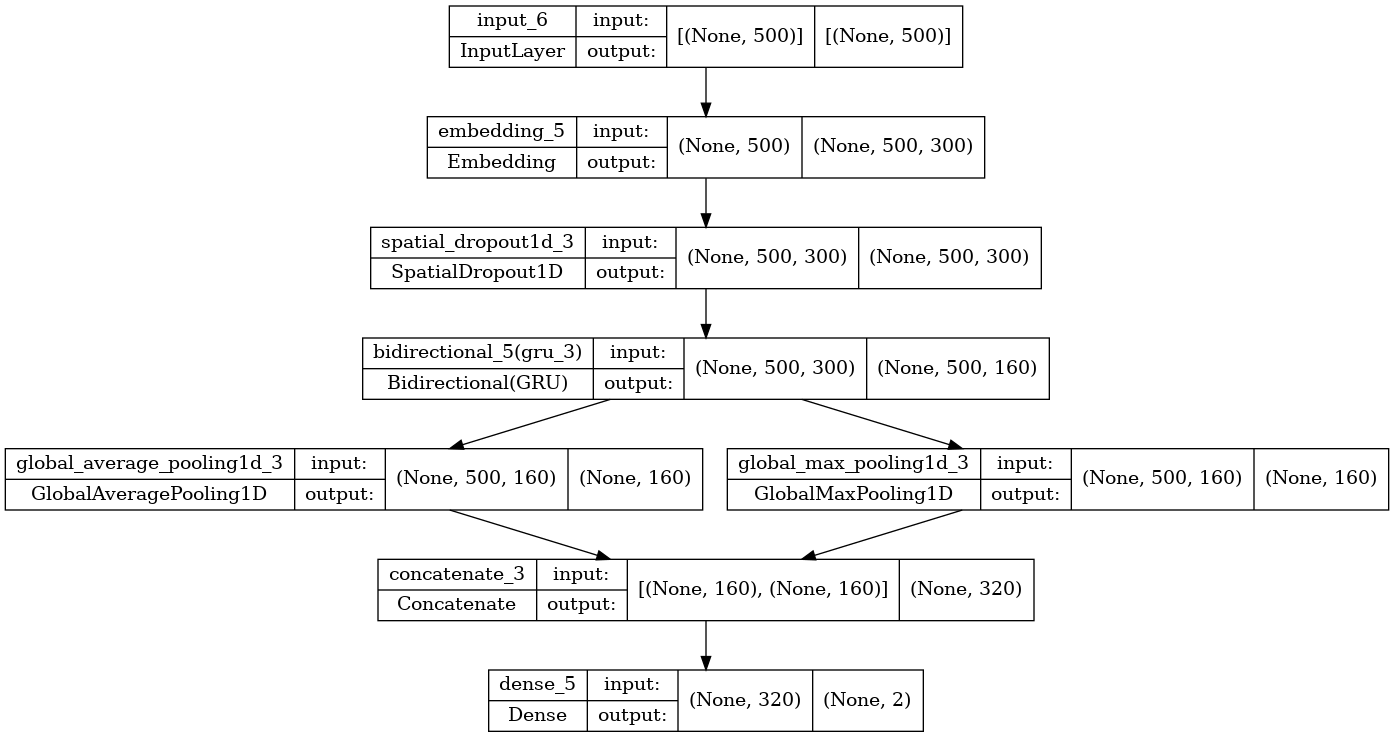

In [41]:


best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

----------------------------------------1. Negative----------------------------------------
This 'documentary' sheds absolutely no light on what it would be like to be backstage during the Hard Knock Life tour. Granted, I wasn't there, but watching this film didn't make me feel like I was. And for a film like this, that's not exactly a compliment. The whole time I watched it, all I could think was, "What are they leaving out?" When it's all over, the only rapper you feel like you have some insight into is DMX, and that's mainly because he just talks about his dogs. A waste of time.<br /><br />3/10


2022-07-18 09:36:10,618: WARNING: 5 out of the last 786 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f0f44915f70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


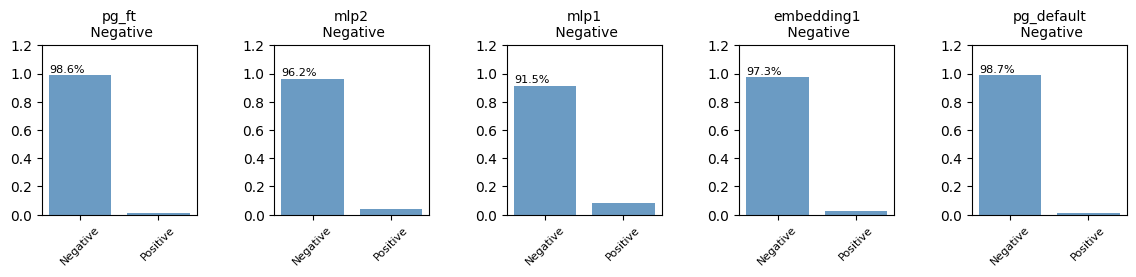

----------------------------------------2. Positive----------------------------------------
I like Breillat's movies, but this one is the best I've seen at balancing animal warmth with sexual intelligence. Anne Parillaud is electric, and the script is amazing - especially considering it's supposed to take place on the set of another of Breillat's movies. You don't have to agree with her take on everything to get a lot out of this. It made me think a lot about vulnerability and power. Try to imagine a male director with Jeanne's openness - not impossible, but a little mind-bending. The unannounced sexual undercurrents that are always present when humans get together to make anything is held up to bright light here, but not a cold light.


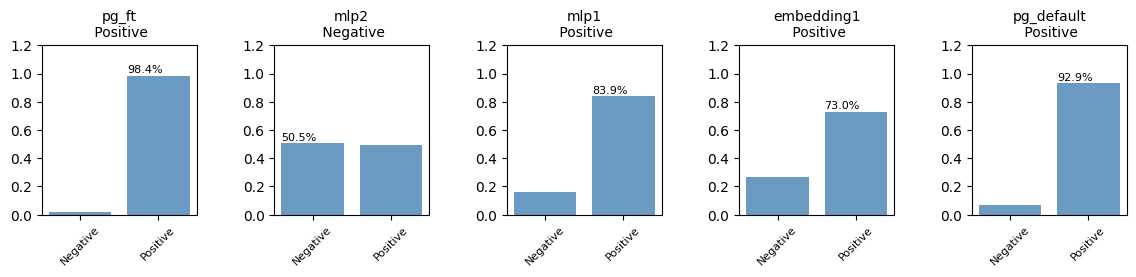

----------------------------------------3. Positive----------------------------------------
Right this may be the wine talking but this could be the best movie I've seen in a very long time. Granted I spent much of the first half an hour wondering what the hell was going on but once I had accepted that I would never understand everything from the subtitles I was able to enjoy the film.<br /><br />Can you really hate a film where a staff turns into a flock of birds that defecate over the enemy? What does character development matter when faced with a lesbian alien princess whose people built the pyramids? Why does Buddha wear seriously blinging diamond earrings? Does any of this matter when faced with the sheer sumptuousness of the visuals and the sly humour of the characters. Any battle for my heart was won once I saw the main protagonist dressed as spider-man - awesome! Many people will complain about a lack of story cohesion but for a fun movie to laugh about with a bunch of mates yo

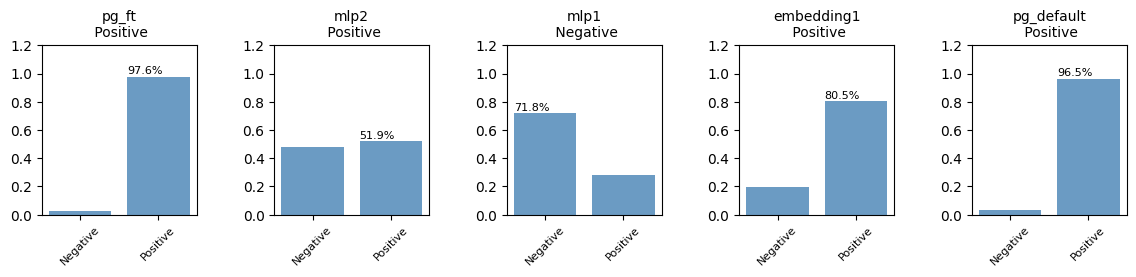

----------------------------------------4. Positive----------------------------------------
This is one of the best presentations of the 60's put on film. Arthur Penn, director of Bonnie and Clyde and Little Big Man, saw that Steve Tesich's outstanding script rang with truth, and from these two talents comes solid cinema. Jodi Thelin's Georgia Miles gives male viewers a hit of pained nostalgia for the archetypal beauty who is almost within our grasps, but, always just out of reach. Just see it, or you cinematic education will be incomplete.


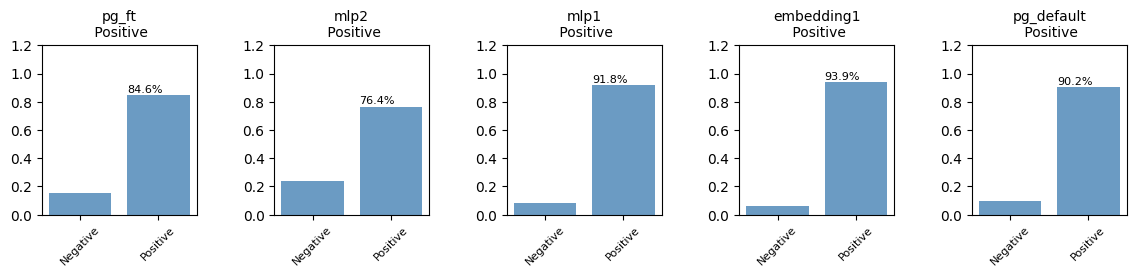

----------------------------------------5. Negative----------------------------------------
I have done some research on Ed Gien, and I have found a few interesting things. Like the fact that Ed Gien, was quiet and a loner, not some buff over bearing jerk as in this movie. I will say that I didn't finish this movie but I will. I will cringe through the fact that all of us, Wisconsinites, talk like we are from Kentucy. You know the funny, but oh so sad factor in this movie, is Wisconsin isn't as hot as they made it look.<br /><br />This movie is not only an insult to Wisconsin people, being a Wisconsite myself, but it is a complete insult to a man that was proved to be an insane, lonely man. He killed two people and the movie couldn't even get that right. Ed didn't get that close and personal and scare people, he shot the two and only people, he killed. So, why do these movies lie and say "BASED ON A TRUE STORY"? This is not based on nothing but the lies the director came up with in his

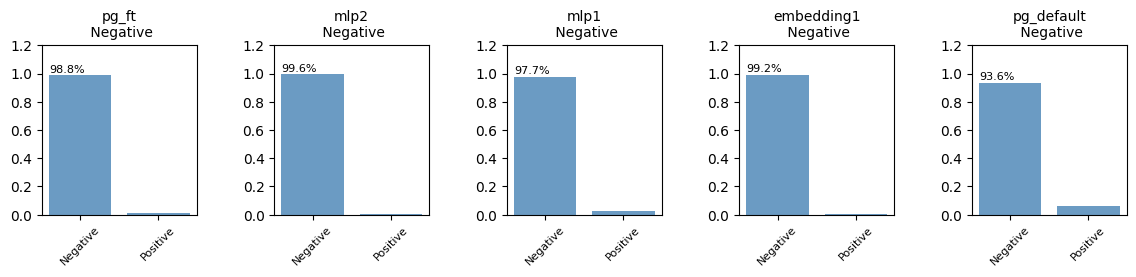

In [42]:
qtf.utils.plot_sample_text_analysis(predictors, test_texts, test_labels,
                                    sample_count=5, show_error_sample=False) 

----------------------------------------1. Positive----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


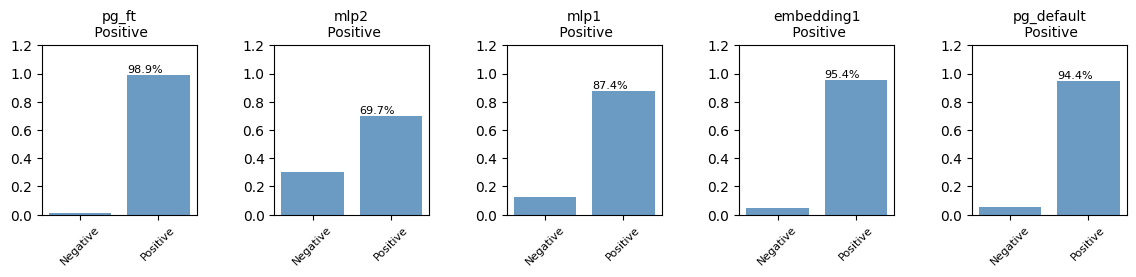

----------------------------------------2. Negative----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


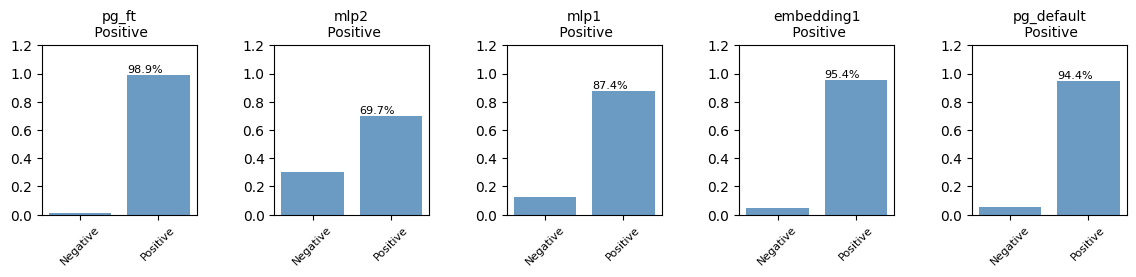

----------------------------------------3. Positive----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


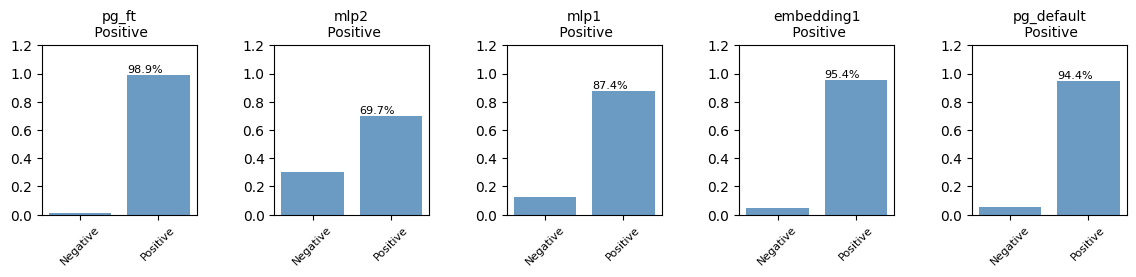

----------------------------------------4. Negative----------------------------------------
Actor turned director Bill Paxton follows up his promising debut, the Gothic-horror "Frailty", with this family friendly sports drama about the 1913 U.S. Open where a young American caddy rises from his humble background to play against his Bristish idol in what was dubbed as "The Greatest Game Ever Played." I'm no fan of golf, and these scrappy underdog sports flicks are a dime a dozen (most recently done to grand effect with "Miracle" and "Cinderella Man"), but some how this film was enthralling all the same.<br /><br />The film starts with some creative opening credits (imagine a Disneyfied version of the animated opening credits of HBO's "Carnivale" and "Rome"), but lumbers along slowly for its first by-the-numbers hour. Once the action moves to the U.S. Open things pick up very well. Paxton does a nice job and shows a knack for effective directorial flourishes (I loved the rain-soaked monta

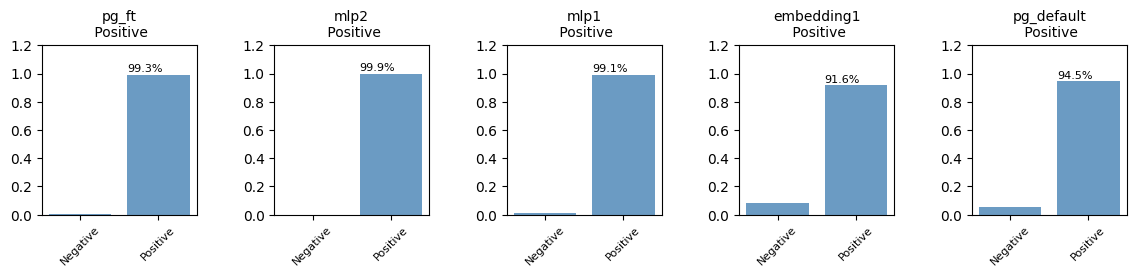

----------------------------------------5. Positive----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


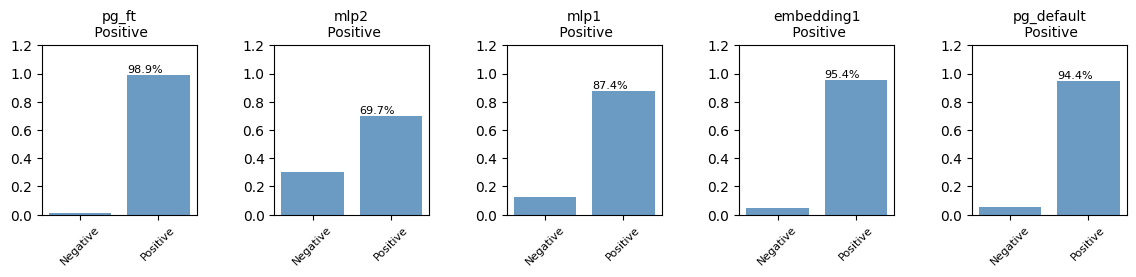

In [43]:
qtf.utils.plot_sample_text_analysis(predictors, test_texts, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [44]:
results = best_predictor.evaluate(test_texts, test_labels)
print(results)

predictions = best_predictor.predict(test_texts)
print(predictions.shape)

{'loss': 0.24139481782913208, 'accuracy': 0.9031999707221985, 'mae': 2.2794880867004395}
(25000, 2)


In [45]:
top1_predictions = best_predictor.predict_top_k(test_texts, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

,precision,recall,f1
Negative,0.905405,0.90048,0.902936
Positive,0.901018,0.90592,0.903463


----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative     0.9054    0.9005    0.9029     12500
    Positive     0.9010    0.9059    0.9035     12500

    accuracy                         0.9032     25000
   macro avg     0.9032    0.9032    0.9032     25000
weighted avg     0.9032    0.9032    0.9032     25000



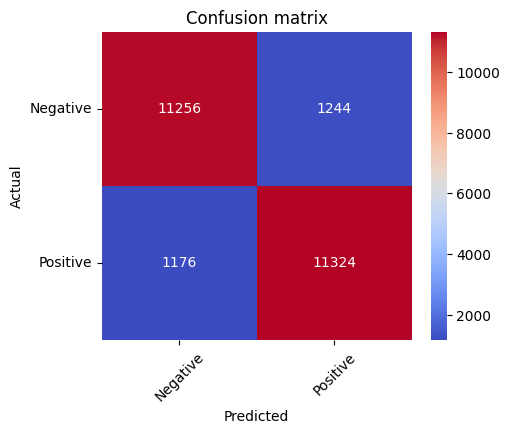

In [46]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)